In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import signal, fftpack
from functools import reduce
import mne
import mplcursors

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import find_nearest_ind
# from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_stim_events, find_nearest_ind

In [4]:
%matplotlib notebook

#### Functions

In [5]:
## from https://github.com/AllenInstitute/ecephys_spike_sorting/blob/master/ecephys_spike_sorting/common/utils.py
def rms(data, maxis=0):

    """
    Computes root-mean-squared voltage of a signal
    Input:
    -----
    data - numpy.ndarray
    Output:
    ------
    rms_value - float
    
    """

    return np.power(np.mean(np.power(data.astype('float32'),2), axis=maxis),0.5)

In [6]:
def get_evoked_traces(data, timestamps, events, plot_before, plot_after, data_sample_rate):
    pre_inds = int(plot_before * data_sample_rate)
    post_inds = int(plot_after * data_sample_rate)
    timex = (np.arange(-pre_inds, post_inds) / data_sample_rate)
    
    evoked_traces = np.zeros((len(timex), np.shape(data)[1], len(events)))
    for j, jtime in enumerate(events):
        zeroind = find_nearest_ind(timestamps, jtime)
        data_inds = np.arange(zeroind-pre_inds, zeroind+post_inds)
        evoked_traces[:,:,j] = data[data_inds,:]
    
    return evoked_traces, timex

In [7]:
### still need to test ###
def get_good_channels(exp_inst):
    TEST_SWEEP = 0
    HI_NOISE_THRESH = 150.0 # default = 50.0 from Npx pipeline analysis
    LO_NOISE_THRESH = 3.0 # default = 3.0 from Npx pipeline analysis
    EARLY_RESPONSE_WINDOW = [0.001, 0.1] # looking in window from 1 to 100 ms for high absolute voltage
    VOLTAGE_THRESH = 1000 # uV
    TRIAL_FRACTION_THRESH = 0.1 # if more than 10% of trials exceed the VOLTAGE_THRESH, it is considered a bad ch

    if exp_inst.experiment_type == 'spontaneous':
        print('This experiment has no stimuli.')
        return
    
    ## Load eeg data and stim log ##
    expstimlog = pd.read_csv(exp_inst.stimulus_log_file)
    eegdata, eegts = exp_inst.load_eegdata()
    ## Cycle through all stim in TEST_SWEEP to get traces ##
    bad_channel_list = []
    sweep_stimlog = expstimlog[expstimlog['sweep']==TEST_SWEEP]
    for st_type in np.sort(sweep_stimlog.stim_type.unique()):
        param_list = np.sort(sweep_stimlog[sweep_stimlog['stim_type']==st_type].parameter.unique())
        for parami in param_list:
            ## Get event times and traces ##
            events = get_stim_events(sweep_stimlog, st_type, parami, TEST_SWEEP, remove_bad_epochs=False)
            event_traces, event_ts = get_evoked_traces(
                    eegdata,
                    eegts,
                    events,
                    1.0,
                    1.0,
                    exp_inst.ephys_params['EEG']['sample_rate']
                )
            ## RMS of baseline signal ##
            baseline_inds = event_ts < -0.005 # 5 ms before stim delivery
            baseline_rms = np.power(np.mean(np.power(event_traces[baseline_inds, :, :].astype('float32'), 2), 0), 0.5)
            bad_channel_list.append(np.squeeze(np.argwhere(
                (np.median(baseline_rms, 1) < LO_NOISE_THRESH) |
                (np.median(baseline_rms, 1) > HI_NOISE_THRESH)
            )))
            ## Max voltage in early response window ##
            early_inds = np.squeeze(np.argwhere((event_ts > EARLY_RESPONSE_WINDOW[0]) & (event_ts < EARLY_RESPONSE_WINDOW[1])))
            early_max_voltage = np.max(np.abs(event_traces[early_inds, :, :]), axis=0)
            bad_channel_list.append(np.squeeze(np.argwhere(
                np.mean(early_max_voltage > VOLTAGE_THRESH, axis=1) > TRIAL_FRACTION_THRESH
            )))
            
    bad_channels = np.unique(np.hstack(bad_channel_list))
    good_channels = np.array([x for x in range(eegdata.shape[1]) if x not in bad_channels])
    
    del expstimlog        
    del eegdata
    del eegts
    
    return good_channels, bad_channels

In [8]:
def get_stim_events(stim_table, stim_type, stim_param, sweep, remove_bad_epochs=True):
    '''
    Returns an array of event onset times (in the masterclock).

    Inputs:
    -------
    stim_table : pd.DataFrame
        Stim log containing columns labeled: 'stim_type', 'parameter', 'sweep',
        and 'good' (optional).
    stim_type : str
        Type of stimulus to select: 'fullscreen', 'auditory', 'biphasic'
    stim_param : str or int
        Specific parameter to choose: 'black', 'white' or 'whitenoise', '10000'
        or current amplitude (as int)
    sweep : int
        Select event times from specified sweep/block
    remove_bad_epochs : bool, default=True
        Optional, will allow subselection of only "good" trials. If the stim log
        does not have the "good" column, it will be ignored.

    Outputs:
    -------
    event_onset_times : np.array
        Onset times for the specified events in the master clock (s).
    '''

    if 'good_trial' in stim_table.columns and remove_bad_epochs:
        return stim_table[
                (stim_table['stim_type'] == stim_type) &
                (stim_table['parameter'] == stim_param) &
                (stim_table['sweep'] == sweep) &
                (stim_table['good_trial'] == True)
                ].onset.values
    else:
        return stim_table[
                (stim_table['stim_type'] == stim_type) &
                (stim_table['parameter'] == stim_param) &
                (stim_table['sweep'] == sweep)
                ].onset.values

In [9]:
### FUNCTION to get bad trials and channels ###
def get_good_trials_chs(exp_inst):
    TRIAL_RMS_THRESH = 200.0
    HI_NOISE_THRESH = 120.0 # default = 50.0 from Npx pipeline analysis
#     LO_NOISE_THRESH = 3.0 # default = 3.0 from Npx pipeline analysis
    SHORT_WINDOW = [0.001, 0.003] # looking in window from 1 to 3 ms for high voltage difference (response-baseline)
    DIFF_THRESH = 200.0 # uV
    CH_FRACTION_THRESH = 0.34
    TRIAL_FRACTION_THRESH = 0.25 # if more than 25% of trials exceed the VOLTAGE_THRESH, it is considered a bad ch

    if exp_inst.experiment_type == 'spontaneous':
        print('This experiment has no stimuli.')
        return
    
    ## Load eeg data and stim log ##
    expstimlog = pd.read_csv(exp_inst.stimulus_log_file)
    expstimlog['good_trial'] = np.zeros(expstimlog.shape[0], dtype='bool')
    eegdata, eegts = exp_inst.load_eegdata()
    ## Cycle through all stim in all sweeps to get traces ##
    channel_dict = {}
    for st_type in np.sort(expstimlog.stim_type.unique()):
        channel_dict[st_type] = {}
        for parami in np.sort(expstimlog.loc[expstimlog.stim_type == st_type, 'parameter'].unique()):
            channel_dict[st_type][parami] = {}
            param_mask = (expstimlog.stim_type == st_type) & (expstimlog.parameter == parami)
            for sweepi in np.sort(expstimlog.loc[param_mask, 'sweep'].unique()):
                ## Get event times and traces ##
                events = get_stim_events(expstimlog, st_type, parami, sweepi, remove_bad_epochs=False)
                event_traces, event_ts = get_evoked_traces(
                        eegdata,
                        eegts,
                        events,
                        1.0,
                        1.0,
                        exp_inst.ephys_params['EEG']['sample_rate']
                    )
                
                ## RMS of baseline signal ##
                full_baseline_inds = event_ts < -0.002 # 2 ms before stim delivery
                baseline_rms = np.power(np.mean(np.power(
                    event_traces[full_baseline_inds, :, :].astype('float32'), 2), 0), 0.5)

                ## Response - baseline voltage diff ##
                short_baseline_inds = np.nonzero((event_ts > -SHORT_WINDOW[1]) & (event_ts < -SHORT_WINDOW[0]))[0]
                short_response_inds = np.nonzero((event_ts > SHORT_WINDOW[0]) & (event_ts < SHORT_WINDOW[1]))[0]
                voltage_diff = np.abs(
                    np.mean(event_traces[short_response_inds,:,:], axis=0) - 
                    np.mean(event_traces[short_baseline_inds,:,:], axis=0)
                )
                
                ## Find good trials ##
                GOOD_TRIALS = np.intersect1d(
                    np.nonzero(np.median(baseline_rms, axis=0) < TRIAL_RMS_THRESH)[0],
                    np.nonzero(np.mean(voltage_diff > DIFF_THRESH, axis=0) <= CH_FRACTION_THRESH)[0],
                    assume_unique=True
                )
                print(GOOD_TRIALS.shape[0])
                ## Find good channels ##
                if GOOD_TRIALS.shape[0] > 0:
                    GOOD_CHS = np.intersect1d(
                        np.nonzero(np.median(baseline_rms[:, GOOD_TRIALS], axis=1) < HI_NOISE_THRESH)[0],
                        np.nonzero(np.mean(voltage_diff[:, GOOD_TRIALS] > DIFF_THRESH, axis=1) < TRIAL_FRACTION_THRESH)[0],
                        assume_unique=True
                    )
                else: # if there are zero GOOD_TRIALS, look at all trials for GOOD_CHS
                    GOOD_CHS = np.intersect1d(
                        np.nonzero(np.median(baseline_rms, axis=1) < HI_NOISE_THRESH)[0],
                        np.nonzero(np.mean(voltage_diff > DIFF_THRESH, axis=1) < TRIAL_FRACTION_THRESH)[0],
                        assume_unique=True
                    )
                
                channel_dict[st_type][parami][sweepi] = GOOD_CHS
                TRIAL_MASK = (
                    (expstimlog.stim_type == st_type) &
                    (expstimlog.parameter == parami) &
                    (expstimlog.sweep == sweepi)
                )
                expstimlog.loc[TRIAL_MASK, 'good_trial'] = np.isin(np.arange(events.shape[0]), GOOD_TRIALS)
    
        
    del eegdata
    del eegts
    
    return expstimlog, channel_dict

In [10]:
### FUNCTION to get bad trials and channels ###
def get_good_trials(exp_inst, known_bad_chs=[]):
    print(known_bad_chs)
    TRIAL_RMS_THRESH = 200.0
    SHORT_WINDOW = [0.001, 0.003] # looking in window from 1 to 3 ms for high voltage difference (response-baseline)
    DIFF_THRESH = 200.0 # uV
    CH_FRACTION_THRESH = 0.34
    V_MAX = 3000.0 # uV

    if exp_inst.experiment_type == 'spontaneous':
        print('This experiment has no stimuli.')
        return
    
    ## Load eeg data and stim log ##
    expstimlog = pd.read_csv(exp_inst.stimulus_log_file)
    expstimlog['good_trial'] = np.zeros(expstimlog.shape[0], dtype='bool')
    eegdata, eegts = exp_inst.load_eegdata()
    ## Cycle through all stim in all sweeps to get traces ##
    for st_type in np.sort(expstimlog.stim_type.unique()):
        for parami in np.sort(expstimlog.loc[expstimlog.stim_type == st_type, 'parameter'].unique()):
            param_mask = (expstimlog.stim_type == st_type) & (expstimlog.parameter == parami)
            for sweepi in np.sort(expstimlog.loc[param_mask, 'sweep'].unique()):
                ## Get event times and traces ##
                events = get_stim_events(expstimlog, st_type, parami, sweepi, remove_bad_epochs=False)
                event_traces, event_ts = get_evoked_traces(
                        eegdata,
                        eegts,
                        events,
                        1.0,
                        1.0,
                        exp_inst.ephys_params['EEG']['sample_rate']
                    )
                ## Remove known bad chs that will skew the results ##
                GOOD_CHS = np.array([x for x in range(eegdata.shape[1]) if x not in known_bad_chs])
                event_traces = event_traces[:, GOOD_CHS, :]
                ## RMS of baseline signal ##
                full_baseline_inds = event_ts < -0.002 # 2 ms before stim delivery
                baseline_rms = np.power(np.mean(np.power(
                    event_traces[full_baseline_inds, :, :].astype('float32'), 2), 0), 0.5)

                ## Response - baseline voltage diff ##
                short_baseline_inds = np.nonzero((event_ts > -SHORT_WINDOW[1]) & (event_ts < -SHORT_WINDOW[0]))[0]
                short_response_inds = np.nonzero((event_ts > SHORT_WINDOW[0]) & (event_ts < SHORT_WINDOW[1]))[0]
                voltage_diff = np.abs(
                    np.mean(event_traces[short_response_inds,:,:], axis=0) - 
                    np.mean(event_traces[short_baseline_inds,:,:], axis=0)
                )
                
                ## Max voltage threshold ##
                longinds = np.nonzero((event_ts < -0.05) | (event_ts > 0.05))[0]
                abs_voltage_max = np.max(np.abs(event_traces[longinds, :]), axis=0)
                
                ## Find good trials ##
#                 GOOD_TRIALS = np.intersect1d(
#                     np.nonzero(np.median(baseline_rms, axis=0) < TRIAL_RMS_THRESH)[0],
#                     np.nonzero(np.mean(voltage_diff > DIFF_THRESH, axis=0) <= CH_FRACTION_THRESH)[0],
#                     assume_unique=True
#                 )
                GOOD_TRIALS = reduce(
                    np.intersect1d,
                    (
                        np.nonzero(np.median(baseline_rms, axis=0) < TRIAL_RMS_THRESH)[0],
                        np.nonzero(np.mean(voltage_diff > DIFF_THRESH, axis=0) <= CH_FRACTION_THRESH)[0],
                        np.nonzero(np.max(abs_voltage_max, axis=0) < V_MAX)[0]
                    )
                )
#                 print(GOOD_TRIALS.shape[0])
                
                TRIAL_MASK = (
                    (expstimlog.stim_type == st_type) &
                    (expstimlog.parameter == parami) &
                    (expstimlog.sweep == sweepi)
                )
                expstimlog.loc[TRIAL_MASK, 'good_trial'] = np.isin(np.arange(events.shape[0]), GOOD_TRIALS)
    
        
    del eegdata
    del eegts
    
    return expstimlog

### Load data

In [26]:
sub_dirs = {
#     '521885': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521885\estim1_2020-07-09_14-23-49\recording1',
#     '521886': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521886\estim1_2020-07-16_13-37-02\recording1',
#     '521887': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521887\estimfull_2020-07-30\experiment1\recordingfull',
#     '543393': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543393\estim1_2020-08-20_13-24-53\experiment1\recording1',
#     '543394': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543394\estim1_2020-08-27_14-32-00\experiment1\recording1',
#     '543395': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543395\estim1_2020-09-03_13-19-42\experiment1\recording1',
#     '543396': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543396\estim_vis1_2020-09-18_12-04-46\experiment1\recording1',
#     '546655': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse546655\estim_vis_2020-10-23_11-01-14\experiment1\recording1',
#     '569069': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse569069\estim_vis2_2021-03-12_10-52-44\experiment1\recording1',
#     '569069': r'F:\EEG_exp\mouse569069\estim_vis1_2021-03-11_11-02-08\experiment1\recording1',
#     '551400': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse551400\estim_vis_2021-01-22_11-07-12\experiment1\recording1',
#     '551397': r'F:\EEG_exp\mouse551397\estim_vis_2021-02-11_10-45-23\experiment1\recording1',
#     '569064': r'F:\EEG_exp\mouse569064\estim_vis_2021-04-08_10-28-24\experiment1\recording1',
    '569073': r'F:\EEG_exp\mouse569073\estim_vis_2021-04-15_10-27-22\experiment1\recording1',
}

sub_bad_chs = {
    '521885': [6,11,12,13,14],
    '521886': [11,12,13,14,15,16,17], # was [10,11,12,13,14,15,16,17,18]
    '521887': [4,11,12,13,14], # was [4,7,11,12,13,14,18]
    '543393': [11,12,13,14],
    '543394': [11,12,13,14,15,17,18,19,20],
    '543395': [11,12,13], # was [11,13]
    '543396': [4,5,7,8,10,11,12,13], # [4,5,7,8,10,11,12,13,14]
    '546655': [],
    '569069': [7,8,9,10,11,12,13,14],
    '551400': [],
    '551397': [28,29],
    '569064': [],
    '569073': [3,4,13],
}

awake_sweeps = {
    '521885': [0], # has multiple amplitudes
    '521886': [0], # has multiple amplitudes
    '521887': [0,1],
    '543393': [0,1,2],
    '543394': [0,1,2],
    '543395': [0,1,2],
    '543396': [0],
    '546655': [0], # has multiple amplitudes
    '569069': [0], # has multiple amplitudes
    '551400': [0], # has multiple amplitudes
    '551397': [0], # has multiple amplitudes
    '569064': [0], # has multiple amplitudes
    '569073': [0], # has multiple amplitudes
}

#### Cycle through data sets

In [27]:
sub_exp = {}
# sub_good_bad_chs = {}
for mousei, recdiri in sub_dirs.items():
    print(mousei)
#     start = time.time()
    sub_exp[mousei] = EEGexp(recdiri, preprocess=False, make_stim_csv=False)
#     sub_good_bad_chs[mousei] = get_chquality_allsweeps(sub_exp[mousei])
#     end = time.time()
#     print('Time to get ch quality dict: {:.2f} s'.format(end-start))

569073
Experiment type: electrical and sensory stimulation


#### Look at each trial's evoked response

In [28]:
plot_before = 1. # s pre-stim
plot_after = 1. # s post-stim

In [29]:
## Loop through all stim events/sweeps and collect traces
sub_traces = {}
sub_spectrum = {}
sub_good_chs = {}
sub_stim_log = {}
for mousei, expi in sub_exp.items():
    print(mousei)
    sub_traces[mousei] = {}
#     stim_log = pd.read_csv(expi.stimulus_log_file)
    start = time.time()
#     stim_log, sub_good_chs[mousei] = get_good_trials_chs(expi)
    stim_log = get_good_trials(expi, known_bad_chs=sub_bad_chs[mousei])
    end = time.time()
    datai, tsi = expi.load_eegdata()
    eegchs = np.arange(0,datai.shape[1])
    good_chs = np.array([x for x in eegchs if x not in sub_bad_chs[mousei]])
    print('Time to test trials: {:.2f} s'.format(end-start))
    
    ## Spectral analysis for all chs, spontaneous ##
    sub_spectrum[mousei] = signal.welch(
        datai[:(120 * expi.ephys_params['EEG']['sample_rate'])+1, :],
        expi.ephys_params['EEG']['sample_rate'],
        nperseg=2 * expi.ephys_params['EEG']['sample_rate'],
        axis=0
    )
    
    for st_type in stim_log.stim_type.unique():
        sub_traces[mousei][st_type] = {}
        
        param_list = np.sort(stim_log[stim_log['stim_type']==st_type].parameter.unique())
        for parami in param_list:
            sub_traces[mousei][st_type][parami] = {}
            
            sweep_list = np.sort(stim_log[(stim_log['stim_type']==st_type) & (stim_log['parameter']==parami)].sweep.unique())
            for sweepi in sweep_list:
#                 print('{} {}, sweep {:d}'.format(st_type, str(parami), sweepi))
                ## Get event times ##
                events = get_stim_events(stim_log, st_type, parami, sweepi, remove_bad_epochs=True)
                ## change remove_bad_epochs to False to study all trials ##
                if len(events) == 0:
#                     print('no good trials found')
                    continue

                ## Get event traces ##
#                 print(len(events))
                event_traces, event_ts = get_evoked_traces(
                    datai,
                    tsi,
                    events,
                    plot_before,
                    plot_after,
                    expi.ephys_params['EEG']['sample_rate']
                )

                ## Store traces ##
                sub_traces[mousei][st_type][parami][sweepi] = [event_ts, event_traces]
    
    sub_stim_log[mousei] = stim_log
    sub_good_chs[mousei] = good_chs
    
    del datai
    del tsi
    del stim_log

569073
[]
Time to test trials: 22.30 s


### Look at the spectra across chs

In [15]:
pickmouse = '569064'
frex = sub_spectrum[pickmouse][0]
Pxx = sub_spectrum[pickmouse][1]

frinds = frex < 200

fig, ax = plt.subplots()

ax.loglog(frex[frinds], Pxx[frinds,:], color='lightgray', linewidth=0.8)
ax.loglog(frex[frinds], np.mean(Pxx, axis=1)[frinds], color='b', linewidth=1.5)
# ax.loglog(fa[frinds], np.mean(Pxx_dena, axis=1)[frinds], color=ancolor, linewidth=2, label=('Anesthetized'))

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('Spectra across first 2 minutes')
# ax.legend()

Text(0.5, 1.0, 'Spectra across first 2 minutes')

In [19]:
pickmouse = '521885'
frex = sub_spectrum[pickmouse][0]
Pxx = sub_spectrum[pickmouse][1]

frinds = frex < 200

fig, ax = plt.subplots()

for ii in range(Pxx.shape[1]):
    ax.loglog(frex[frinds], Pxx[frinds, ii], linewidth=1, label=str(ii))

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('Spectra across first 2 minutes')
ax.legend()

## Use MNE to look at avg traces

Create info object for MNE

In [55]:
subject = '551397'

ch_list = np.arange(0, 30)
ch_names = [str(x) for x in ch_list]
info = mne.create_info(ch_names=ch_names, sfreq=sub_exp[subject].ephys_params['EEG']['sample_rate'], ch_types='eeg')
# can add bad channels to info

Create events dict and array

In [56]:
event_num = 0
event_id_dict = {}
data_list = []
# ts_list = []
event_list = []
for st_type, paramdict in sub_traces[subject].items():
    for parami, sweepdict in paramdict.items():
        for sweepi, datadict in sweepdict.items():
            event_tag = st_type + '_' + str(parami) + '_' + str(sweepi)
            event_id_dict[event_tag] = event_num
            event_list.append(np.array([(event_num*5000), 0, event_num]))
            
            ## concatenate all averaged data (epochs x chs x time) ##
            data_list.append(np.mean(datadict[1], axis=2))
            
            event_num += 1
avg_traces = np.dstack(data_list).T
event_info = np.vstack(event_list)

In [57]:
avg_epochs = mne.EpochsArray(avg_traces*1e-6, info, event_info, tmin=plot_before, event_id=event_id_dict)

15 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


In [58]:
event_info

array([[    0,     0,     0],
       [ 5000,     0,     1],
       [10000,     0,     2],
       [15000,     0,     3],
       [20000,     0,     4],
       [25000,     0,     5],
       [30000,     0,     6],
       [35000,     0,     7],
       [40000,     0,     8],
       [45000,     0,     9],
       [50000,     0,    10],
       [55000,     0,    11],
       [60000,     0,    12],
       [65000,     0,    13],
       [70000,     0,    14]])

<ipython-input-59-90256e625ebe>:2: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  avg_epochs.plot(scalings=scalings, n_epochs=20, n_channels=30, events=event_info, event_id=event_id_dict)


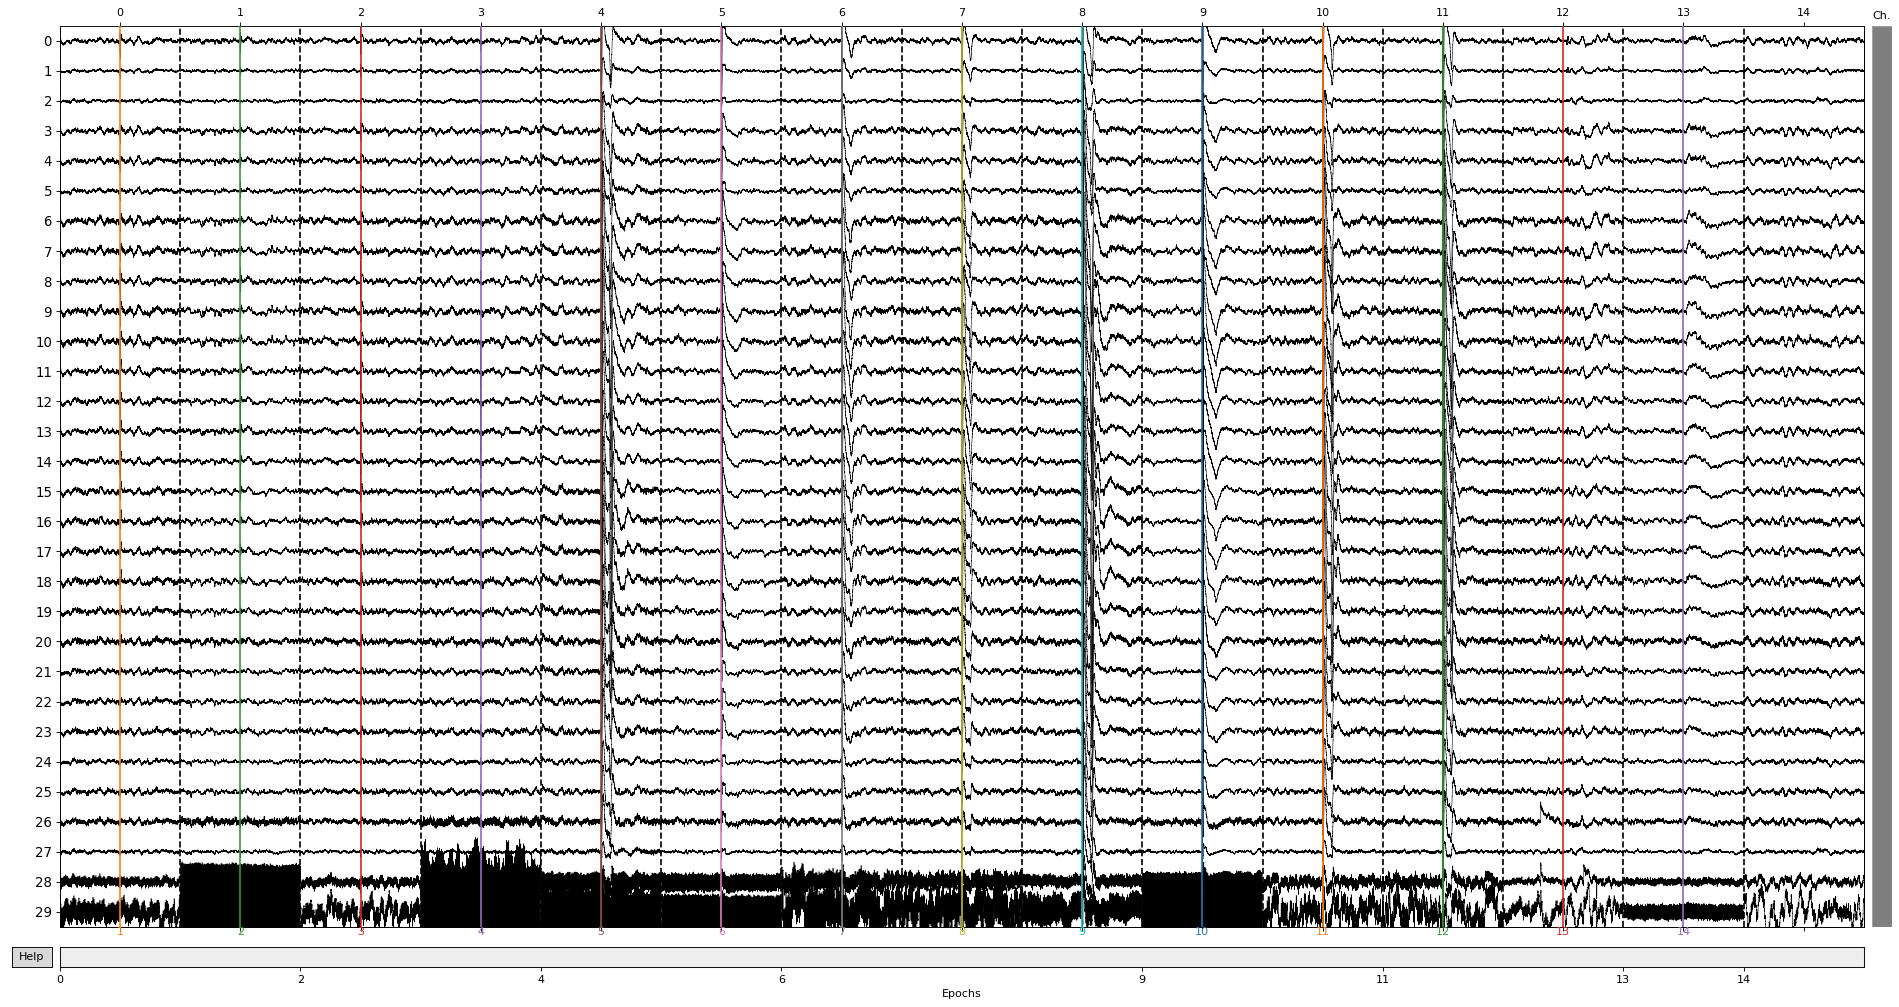

Dropped 0 epochs: 
Channels marked as bad: ['28', '29']


In [59]:
scalings = {'eeg': 100e-6}
avg_epochs.plot(scalings=scalings, n_epochs=20, n_channels=30, events=event_info, event_id=event_id_dict)

{'biphasic_70_0': 0, 'biphasic_50_0': 1, 'biphasic_90_0': 2, 'fullscreen_white_0': 3, 'biphasic_70_1': 4, 'biphasic_50_1': 5, 'biphasic_90_1': 6, 'fullscreen_white_1': 7, 'biphasic_70_2': 8, 'biphasic_50_2': 9, 'biphasic_90_2': 10, 'fullscreen_white_2': 11, 'biphasic_70_3': 12, 'biphasic_50_3': 13, 'biphasic_90_3': 14}


### Look at a subject's traces across different stimuli/sweeps

In [30]:
pickmouse = '569073'
prex = .5 # s
postx = .5 # s
ylimit = 1. # mV
sep = 0.2

for st_type, paramdict in sub_traces[pickmouse].items():
    for parami, sweepdict in paramdict.items():
        for sweepi, datadict in sweepdict.items():
            
            # plot traces
            timex = datadict[0]
            avg_traces = np.mean(datadict[1], axis=2)/1000
            xinds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))
            
            fig, ax = plt.subplots()
            for chi in range(avg_traces.shape[1]):
                if chi in sub_good_chs[pickmouse]:
                    tracec = 'k'
                else:
                    tracec = 'r'
                ax.plot(timex[xinds], avg_traces[xinds,chi]+chi*sep, color=tracec, linewidth=1.0)
            
            ax.set_xlim([-prex, postx])
            ax.set_yticks(np.arange(0, (chi+1)*sep, sep))
            ax.set_yticklabels(eegchs)
#             for ytick in ax.get_yticklabels():
#                 if int(ytick.get_text()) in bad_chs[pickmouse]:
#                     ytick.set_color('m')
            ax.set_title('Mouse {:s}, {:s} {:s}, sweep {:d}'.format(pickmouse, st_type, str(parami), sweepi))

### Plot all subjects' butterfly plots

<IPython.core.display.Javascript object>


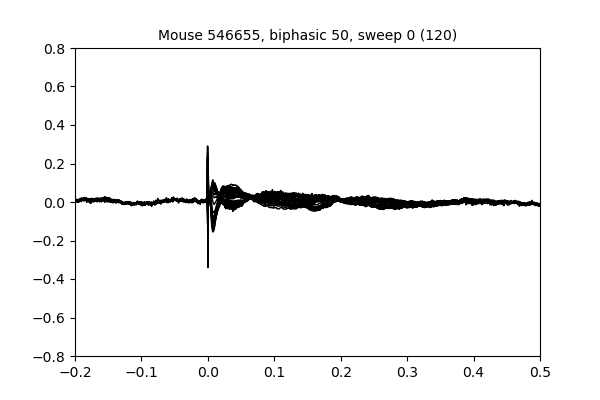

<IPython.core.display.Javascript object>


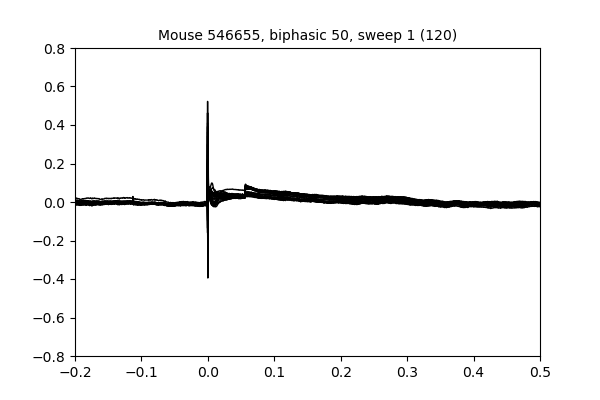

<IPython.core.display.Javascript object>


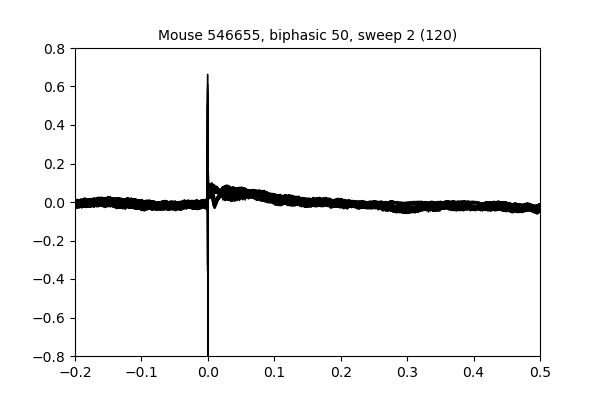

<IPython.core.display.Javascript object>


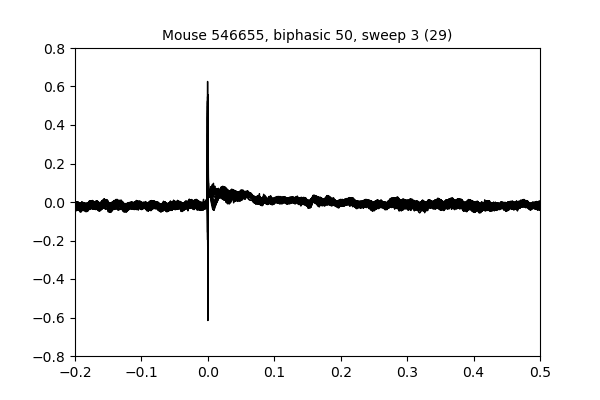

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


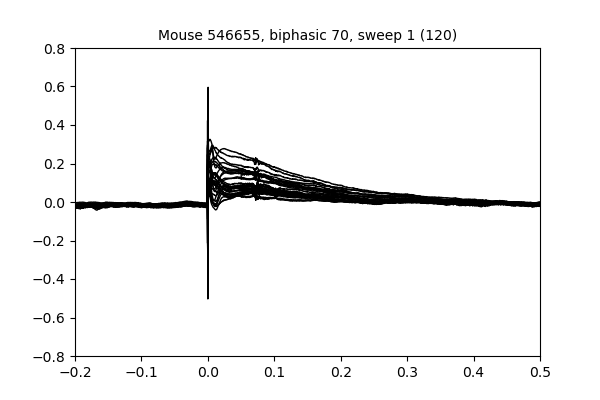

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


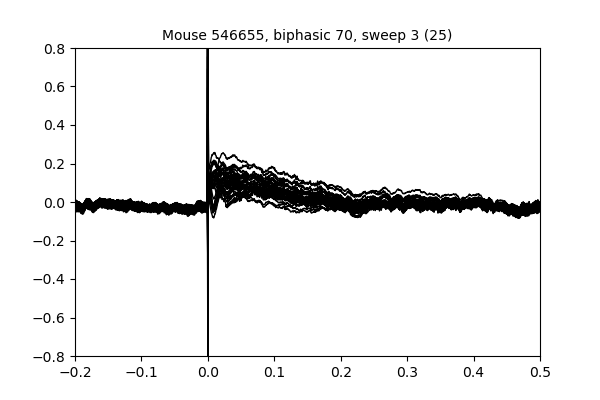

<IPython.core.display.Javascript object>


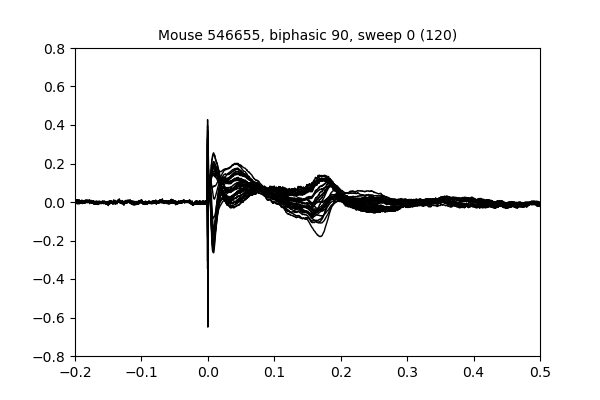

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


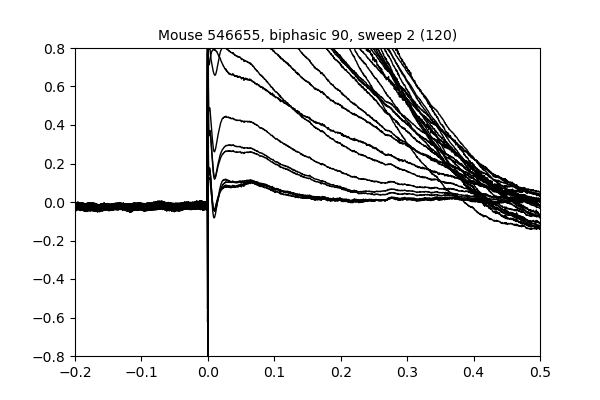

<IPython.core.display.Javascript object>


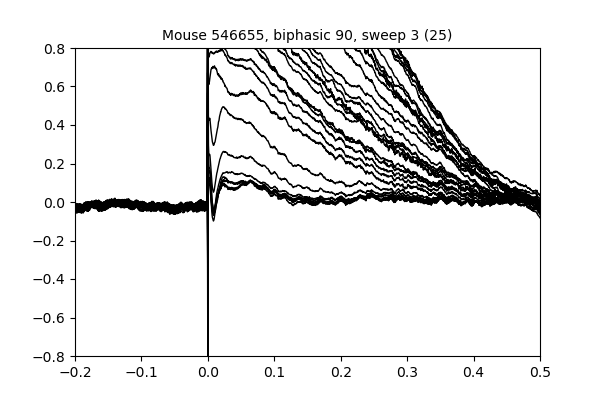

<IPython.core.display.Javascript object>


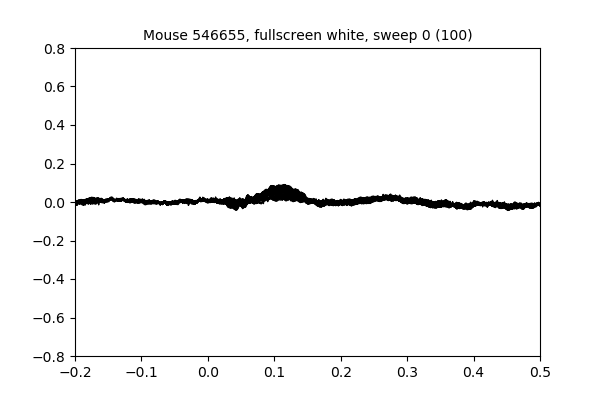

<IPython.core.display.Javascript object>


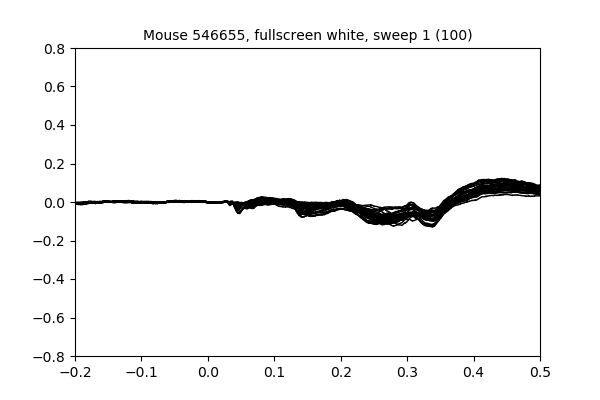

<IPython.core.display.Javascript object>


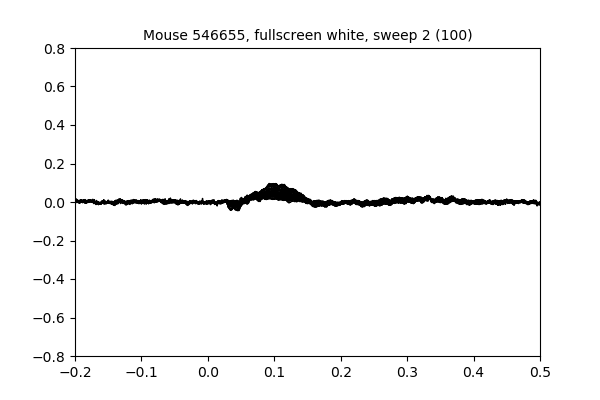

<IPython.core.display.Javascript object>


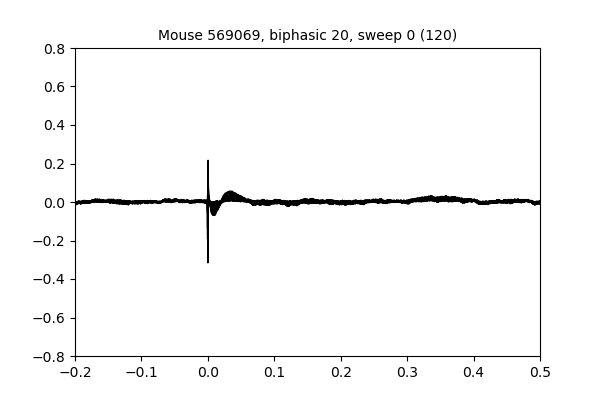

<IPython.core.display.Javascript object>


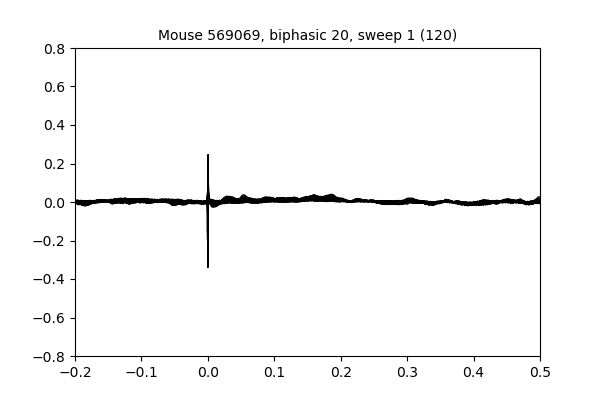

<IPython.core.display.Javascript object>


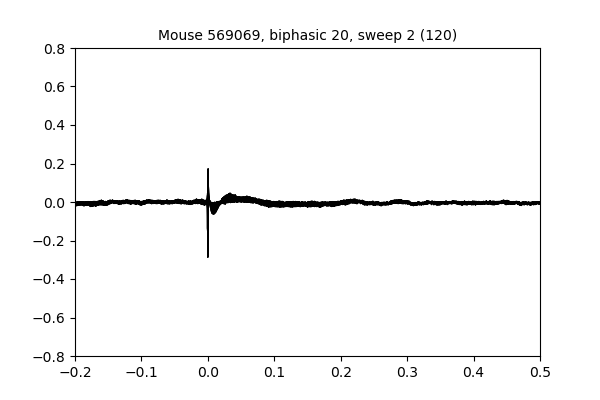

<IPython.core.display.Javascript object>


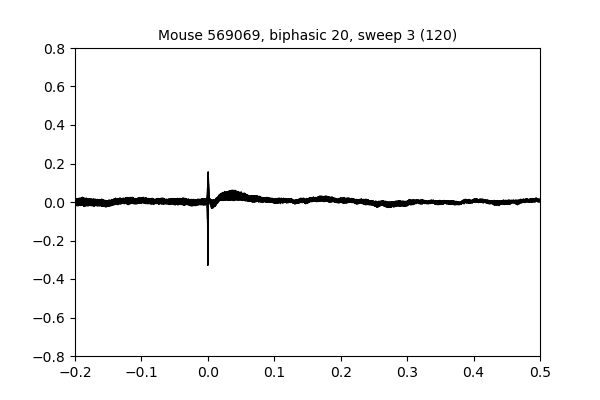

<IPython.core.display.Javascript object>


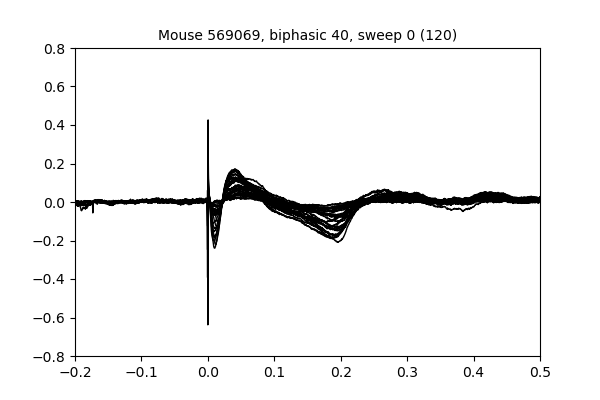

<IPython.core.display.Javascript object>


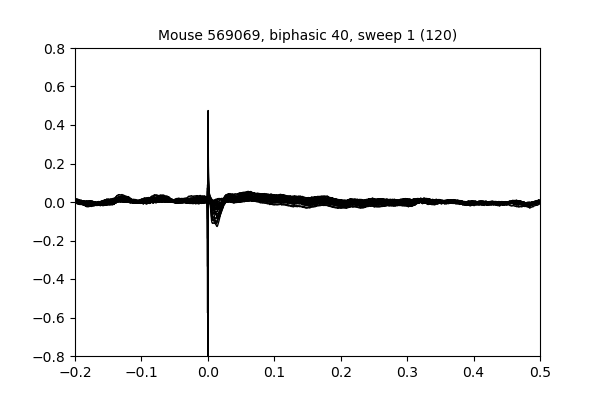

<IPython.core.display.Javascript object>


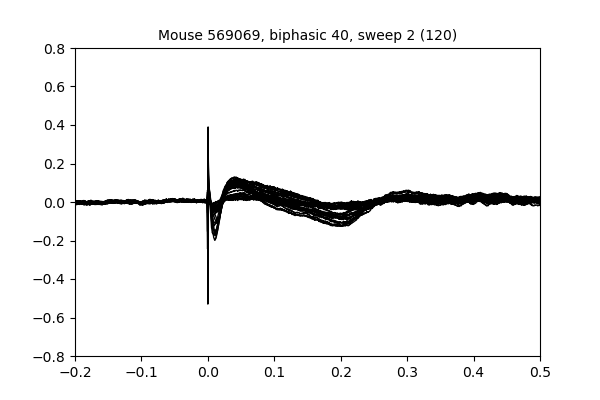

<IPython.core.display.Javascript object>


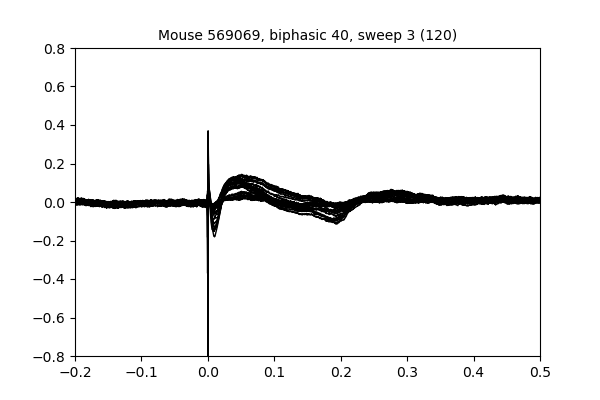

<IPython.core.display.Javascript object>


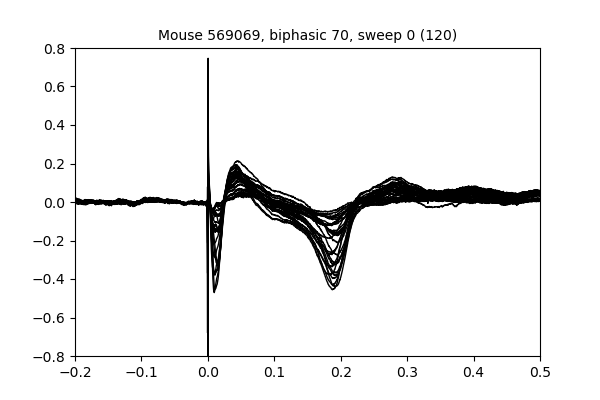

<IPython.core.display.Javascript object>


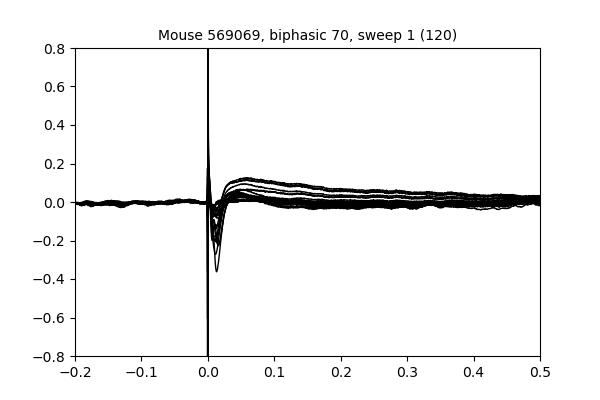

<IPython.core.display.Javascript object>


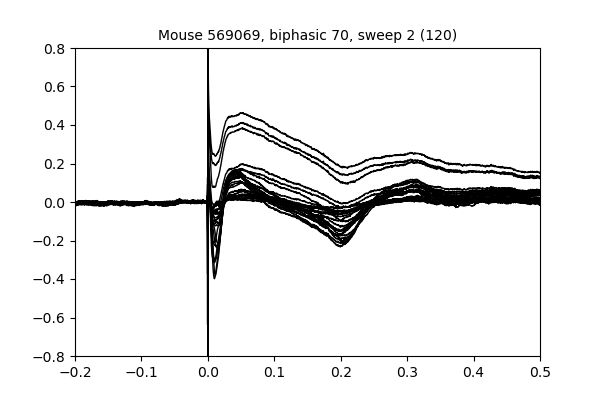

<IPython.core.display.Javascript object>


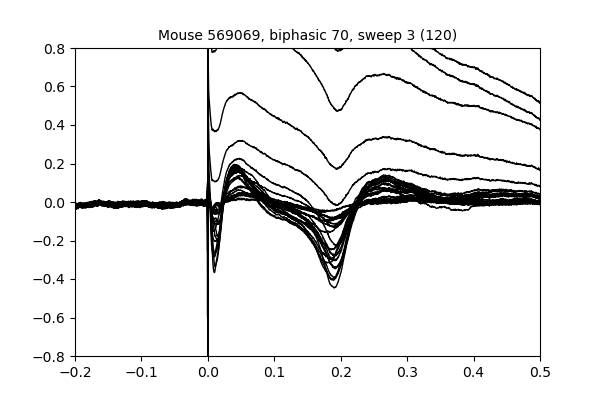

<IPython.core.display.Javascript object>


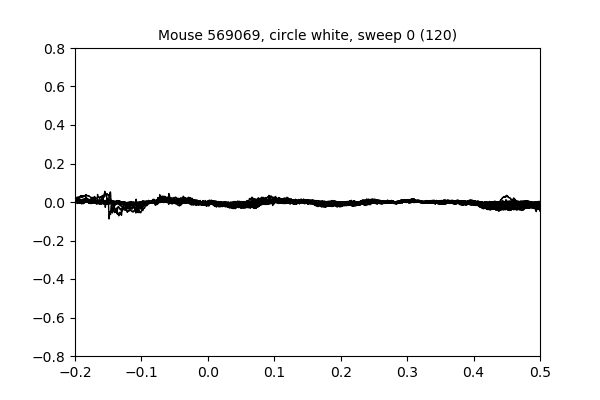

<IPython.core.display.Javascript object>


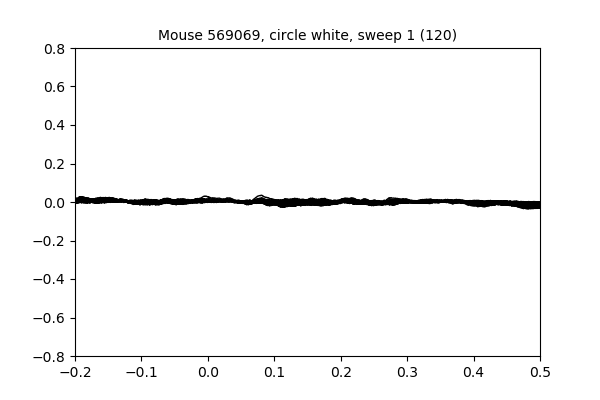

<IPython.core.display.Javascript object>


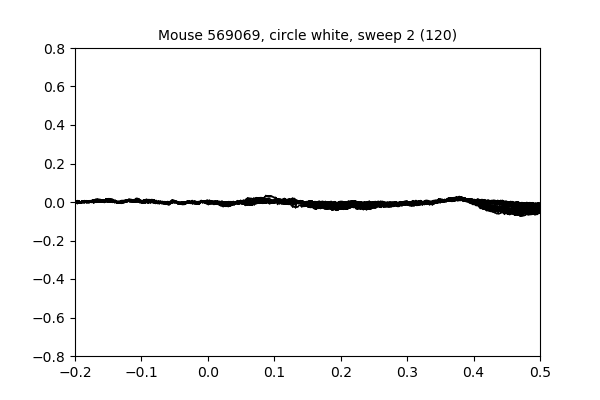

<IPython.core.display.Javascript object>


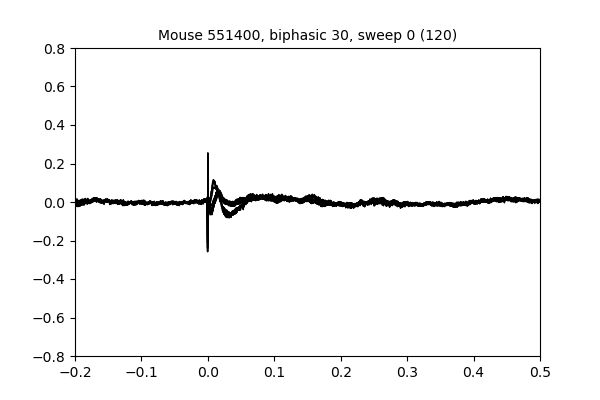

<IPython.core.display.Javascript object>


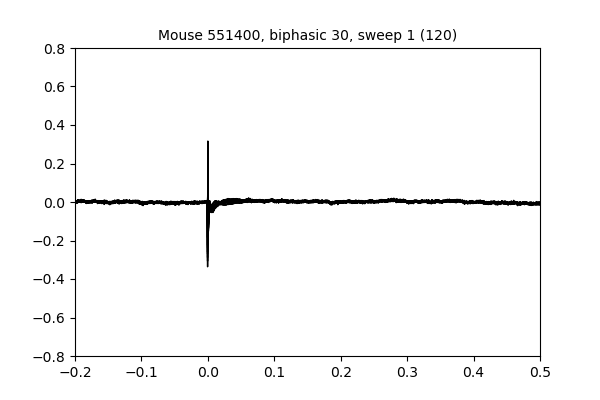

<IPython.core.display.Javascript object>


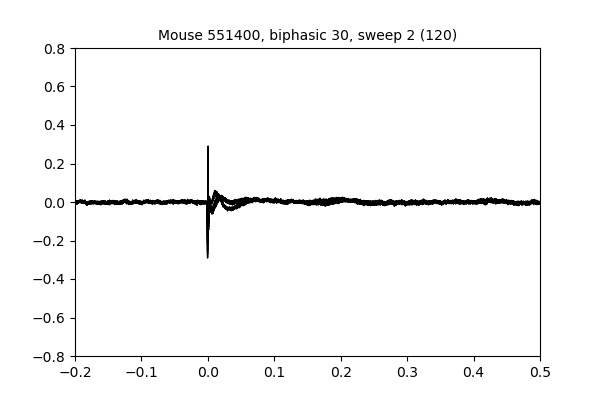

<IPython.core.display.Javascript object>


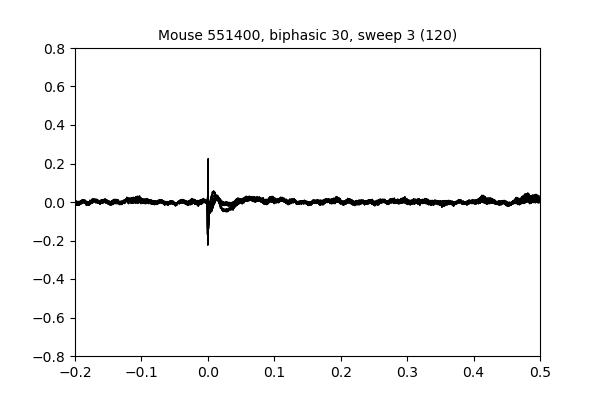

<IPython.core.display.Javascript object>


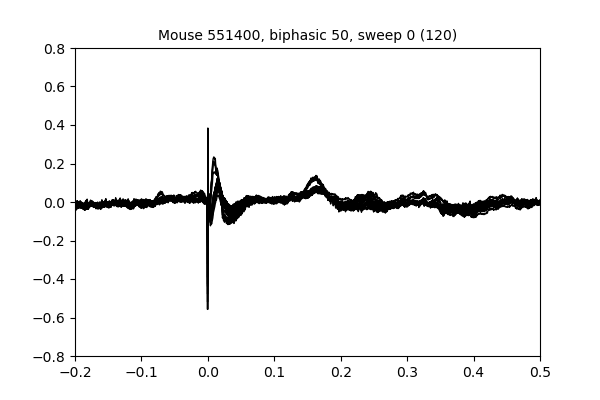

<IPython.core.display.Javascript object>


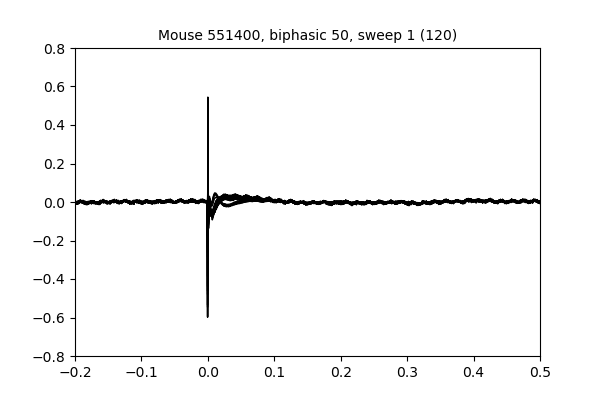

<IPython.core.display.Javascript object>


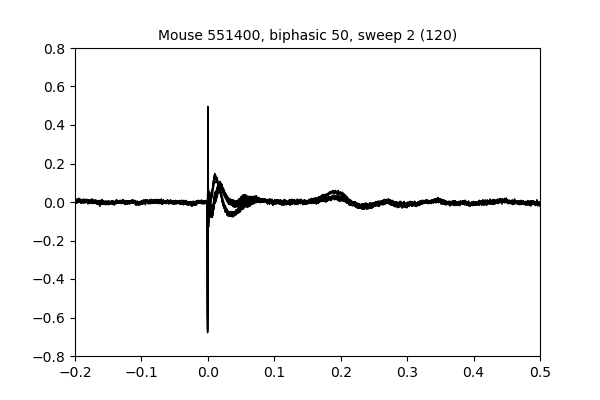

<IPython.core.display.Javascript object>


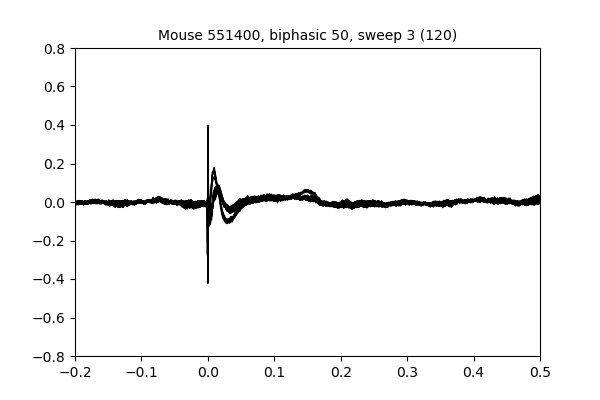

<IPython.core.display.Javascript object>


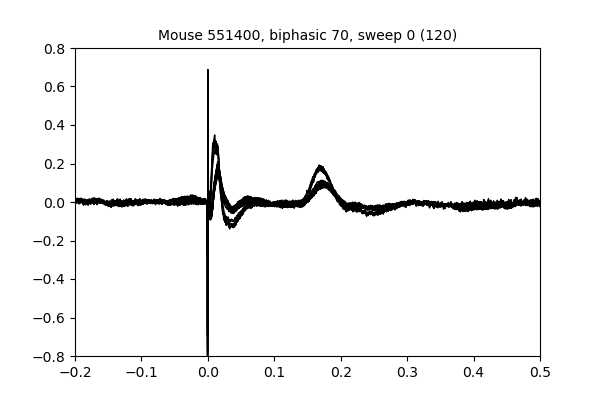

<IPython.core.display.Javascript object>


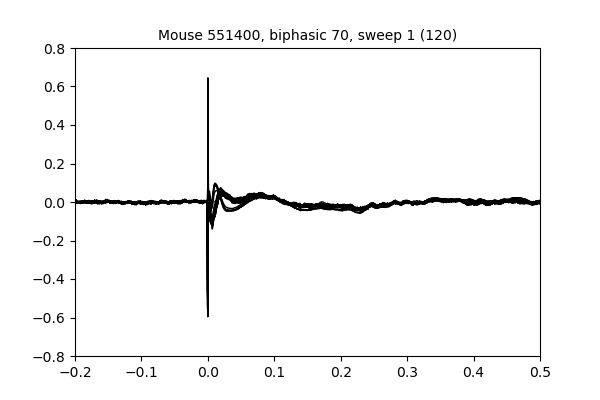

<IPython.core.display.Javascript object>


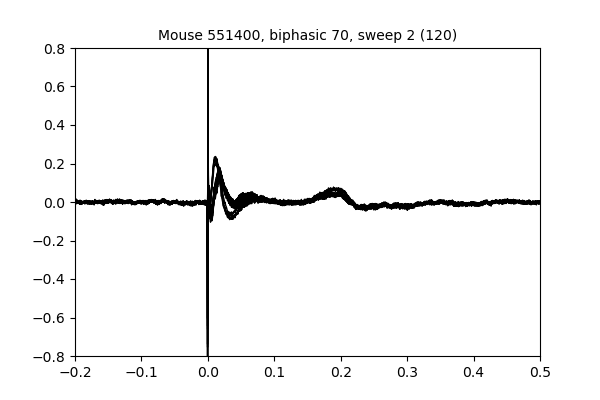

<IPython.core.display.Javascript object>


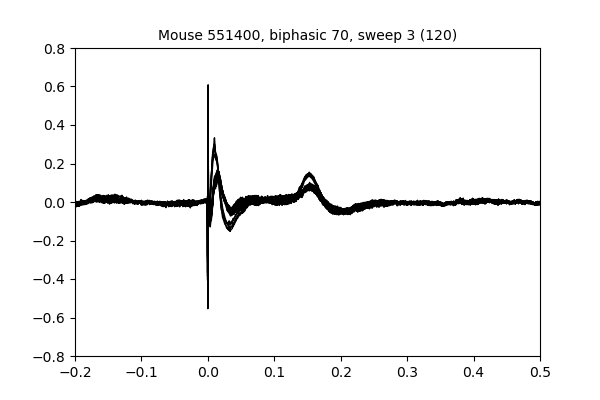

<IPython.core.display.Javascript object>


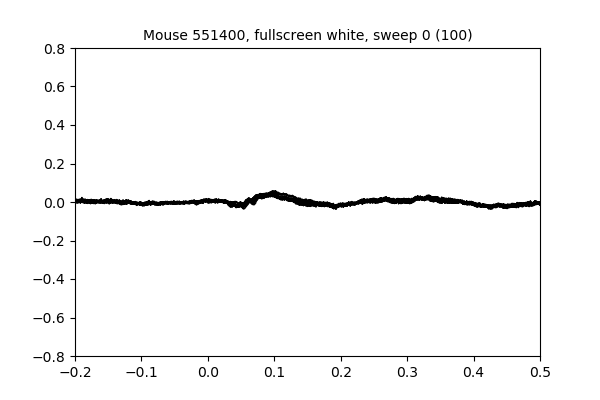

<IPython.core.display.Javascript object>


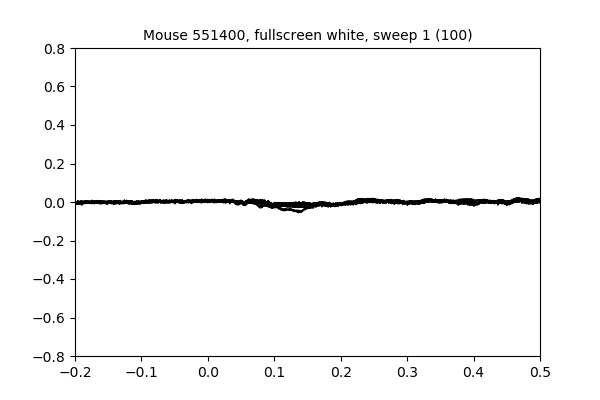

<IPython.core.display.Javascript object>


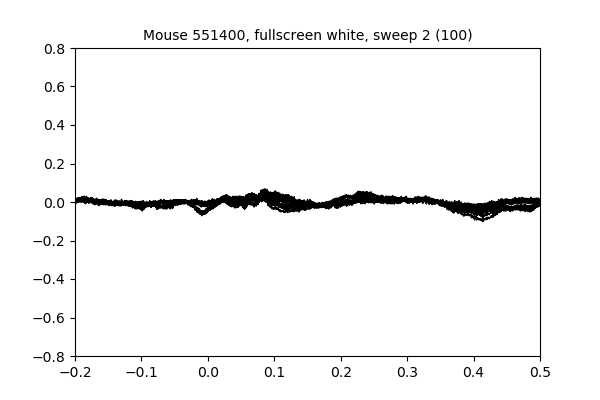

<IPython.core.display.Javascript object>


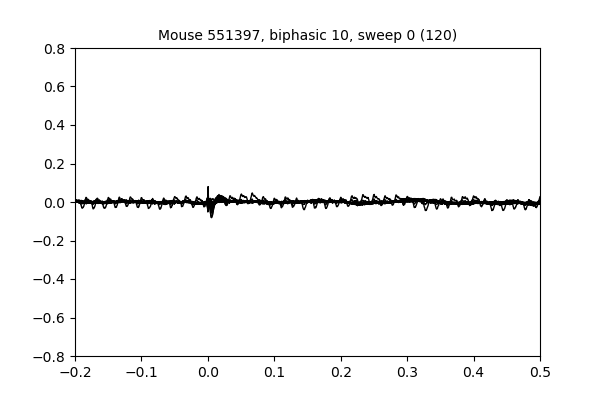

<IPython.core.display.Javascript object>


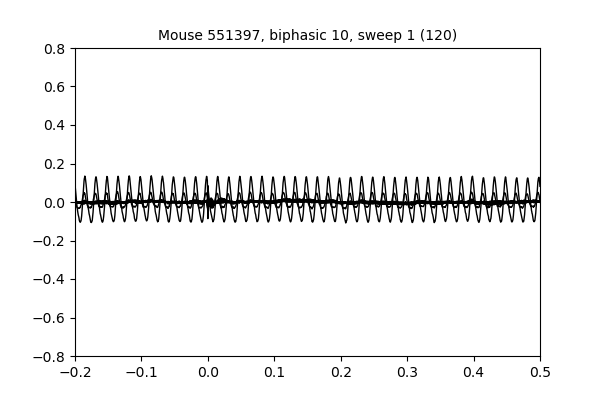

<IPython.core.display.Javascript object>


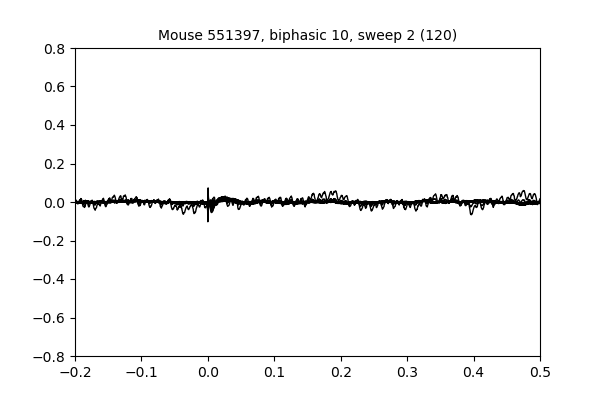

<IPython.core.display.Javascript object>


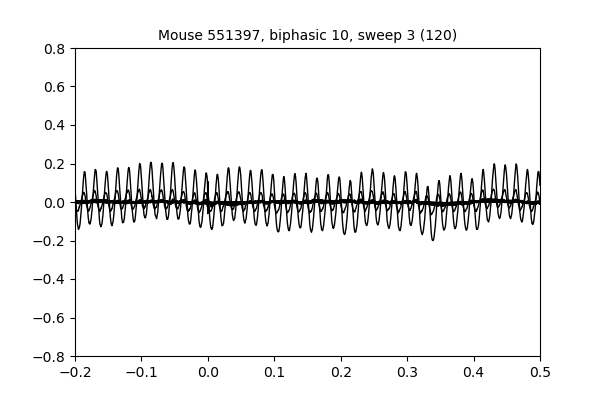

<IPython.core.display.Javascript object>


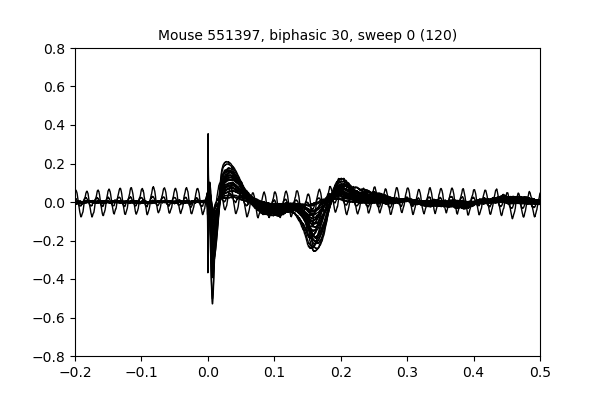

<IPython.core.display.Javascript object>


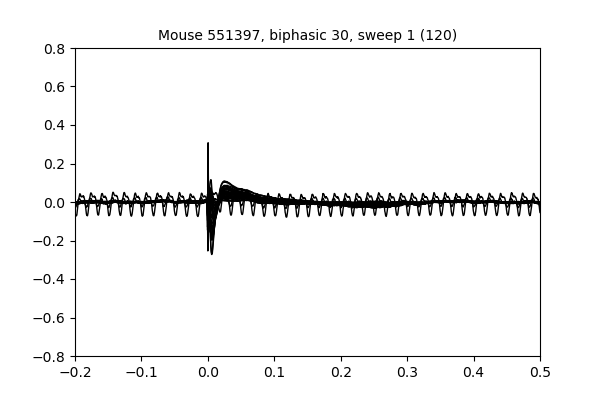

<IPython.core.display.Javascript object>


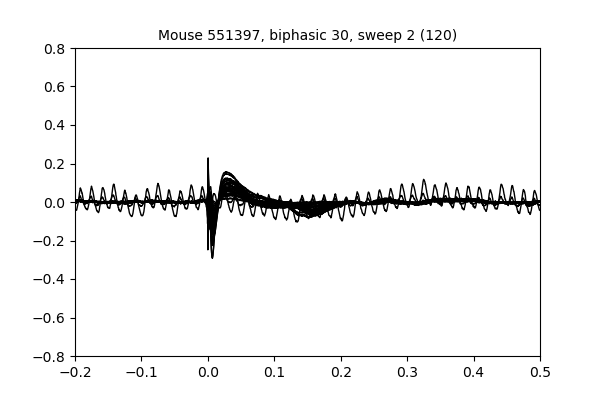

<IPython.core.display.Javascript object>


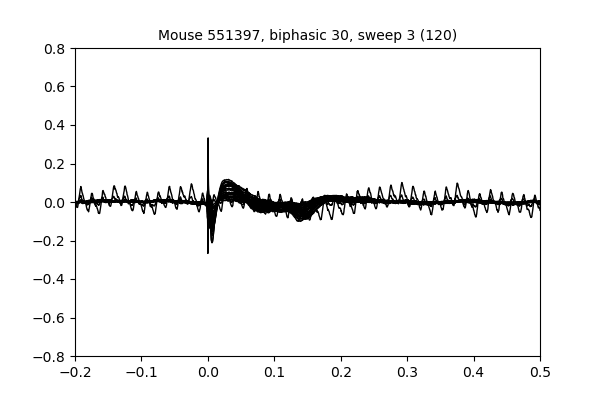

<IPython.core.display.Javascript object>


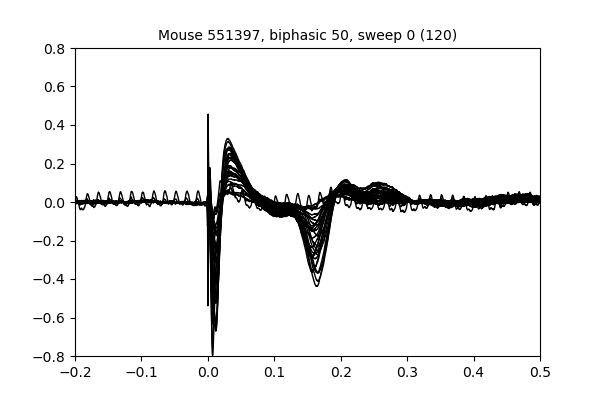

<IPython.core.display.Javascript object>


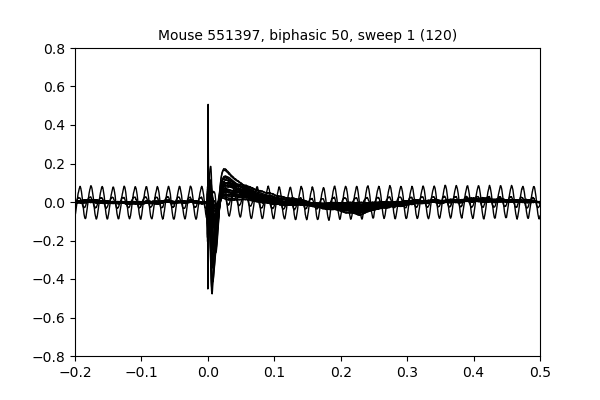

<IPython.core.display.Javascript object>


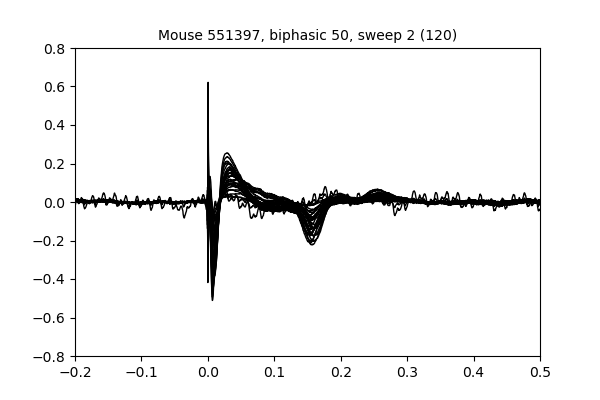

<IPython.core.display.Javascript object>


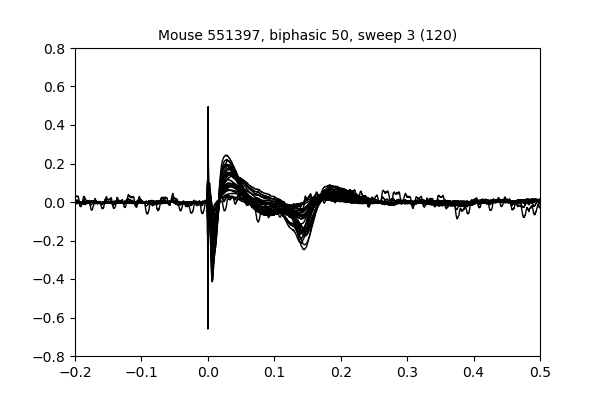

<IPython.core.display.Javascript object>


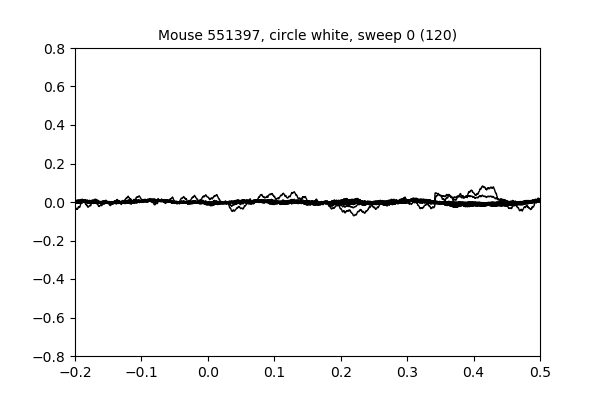

<IPython.core.display.Javascript object>


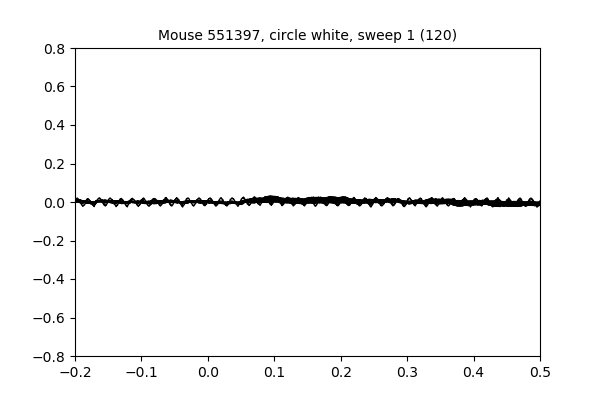

<IPython.core.display.Javascript object>


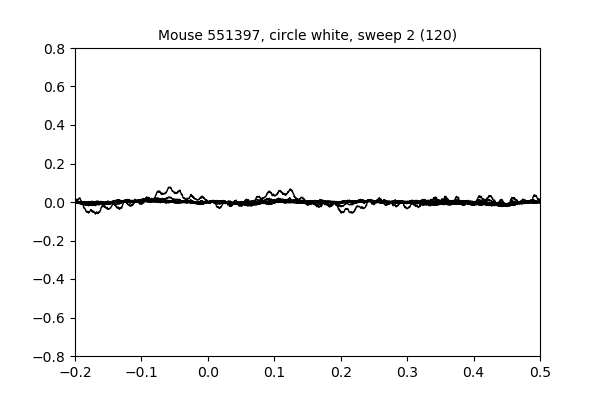

In [15]:
prex = .2 # s
postx = .5 # s
ylimit = 0.8 # mV

for mousei, alldatadict in sub_traces.items():
    for st_type, paramdict in alldatadict.items():
        for parami, sweepdict in paramdict.items():
            for sweepi, datadict in sweepdict.items():

                # plot traces
                timex = datadict[0]
                avg_traces = np.mean(datadict[1], axis=2)/1000
                xinds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

                fig, ax = plt.subplots(figsize=(6,4))
                for chi in range(avg_traces.shape[1]):
#                     if chi in sub_good_chs[mousei][st_type][parami][sweepi]:
#                         tracec = 'k'
#                     else:
#                         tracec = 'r'
                    ax.plot(timex[xinds], avg_traces[xinds,chi], color='k', linewidth=1.0)

                ax.set_xlim([-prex, postx])
                ax.set_ylim([-ylimit, ylimit])
                ax.set_title('Mouse {:s}, {:s} {:s}, sweep {:d} ({:d})'.format(mousei, st_type, str(parami), sweepi, datadict[1].shape[2]))

## Bad chs: looking at individual subjects and testing noise metrics

#### Plot trials

In [25]:
pickmouse = '569069'
pickstim = 'biphasic'
pickparam = '60'
picksweep = 0

In [29]:
## single ch, all trials ##
cha = 13

sc_trace_data = sub_traces[pickmouse][pickstim][pickparam][picksweep][1][:, cha, :]
sc_timex = sub_traces[pickmouse][pickstim][pickparam][picksweep][0]

## Evaluate RMS in baseline for histogram ##
baseline_inds = sc_timex < -0.001
sc_baseline_rms_values = rms(sc_trace_data[baseline_inds, :])

## Response - baseline voltage diff ##
blinds = np.squeeze(np.argwhere((sc_timex > -0.003) & (sc_timex < -0.001)))
respinds = np.squeeze(np.argwhere((sc_timex > 0.001) & (sc_timex < 0.003)))
sc_meandiff = np.abs(np.mean(sc_trace_data[respinds,:], axis=0) - np.mean(sc_trace_data[blinds,:], axis=0))

## Max voltage ##
longinds = np.nonzero((event_ts < -0.05) | (event_ts > 0.05))[0]
voltmax = np.max(np.abs(sc_trace_data[longinds, :]), axis=0)

fig, axs = plt.subplots(1, 4, figsize=(12,3))

axs[0].plot(sc_timex, sc_trace_data, color='k', linewidth=0.6, alpha=0.6)
axs[0].plot(sc_timex, np.mean(sc_trace_data, axis=1), color='r', linewidth=1)
axs[0].set_xlim([sc_timex[0], sc_timex[-1]])

axs[1].hist(sc_baseline_rms_values)
axs[1].set_title('Baseline RMS values')

axs[2].hist(sc_meandiff)
axs[2].set_title('Response - baseline voltage diff')

axs[3].hist(voltmax)
axs[3].set_title('Max baseline/response abs voltage')

Text(0.5, 1.0, 'Max baseline/response abs voltage')

Test bad chs - bad trials

In [27]:
## all chs, all trials ##
trace_data = sub_traces[pickmouse][pickstim][pickparam][picksweep][1][:, :, :]
timex = sub_traces[pickmouse][pickstim][pickparam][picksweep][0]

## Evaluate RMS in baseline for histogram ##
baseline_inds = timex < -0.001
baseline_rms_values = rms(trace_data[baseline_inds,:,:])

## Response - baseline voltage diff ##
blinds = np.squeeze(np.argwhere((timex > -0.003) & (timex < -0.001)))
respinds = np.squeeze(np.argwhere((timex > 0.001) & (timex < 0.003)))
meandiff = np.abs(np.mean(trace_data[respinds,:,:], axis=0) - np.mean(trace_data[blinds,:,:], axis=0))

## Max voltage ##
longinds = np.nonzero((timex < -0.05) | (timex > 0.05))[0]
voltmax = np.max(np.abs(trace_data[longinds, :]), axis=0)

Find bad trials first

Find good trials first

In [28]:
print('Total trials in this sweep: {:d}'.format(trace_data.shape[2]))

RMS_THRESH = 200
VOLT_DIFF_THRESH = 200
CH_FRACTION_THRESH = 0.34
V_MAX = 3000.0

## Look at baseline RMS first ##
rms_good_trials = np.nonzero(np.mean(baseline_rms_values, axis=0) < RMS_THRESH)[0]
print('Number of trials with low baseline noise: {:d}'.format(len(rms_good_trials)))

## Look at voltage diff ##
# diff_good_trials = np.nonzero(np.median(meandiff, axis=0) < VOLT_DIFF_THRESH)[0]
diff_good_trials = np.nonzero(np.mean(meandiff > VOLT_DIFF_THRESH, axis=0) <= CH_FRACTION_THRESH)[0]
print('Number of trials with low voltage difference: {:d}'.format(len(diff_good_trials)))

## Look at max abs voltage
maxv_good_trials = np.nonzero(np.max(voltmax, axis=0) < V_MAX)[0]
print('Number of trials with low max voltage: {:d}'.format(len(maxv_good_trials)))

## Combine ##
good_trials = reduce(np.intersect1d, (rms_good_trials, diff_good_trials, maxv_good_trials))
# good_trials = np.intersect1d(rms_good_trials, diff_good_trials, assume_unique=True)
print(len(good_trials))

Total trials in this sweep: 120
Number of trials with low baseline noise: 0
Number of trials with low voltage difference: 120
Number of trials with low max voltage: 0
0


In [75]:
tri = 90
print(np.mean(baseline_rms_values, axis=0)[tri])
print(np.mean(meandiff > VOLT_DIFF_THRESH, axis=0)[tri])

131.59575
0.0


In [38]:
np.sum(meandiff>VOLT_DIFF_THRESH, 0)[11]

0

<IPython.core.display.Javascript object>


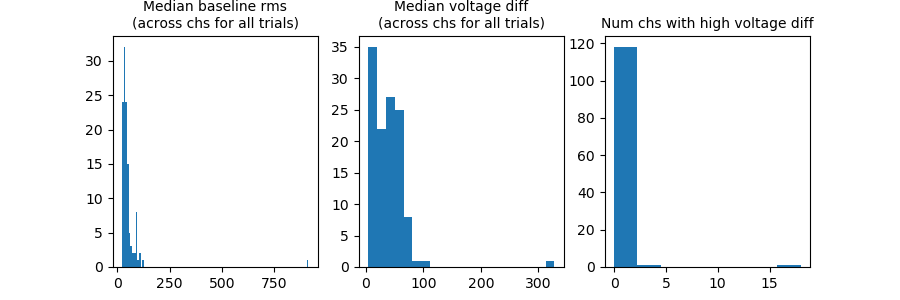

Text(0.5, 1.0, 'Num chs with high voltage diff')

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(9,3))
axs[0].hist(np.median(baseline_rms_values, axis=0))
axs[0].set_title('Median baseline rms\n(across chs for all trials)')
axs[1].hist(np.median(meandiff, axis=0))
axs[1].set_title('Median voltage diff\n(across chs for all trials)')
axs[2].hist(np.sum(meandiff > VOLT_DIFF_THRESH, axis=0))
axs[2].set_title('Num chs with high voltage diff')

<IPython.core.display.Javascript object>


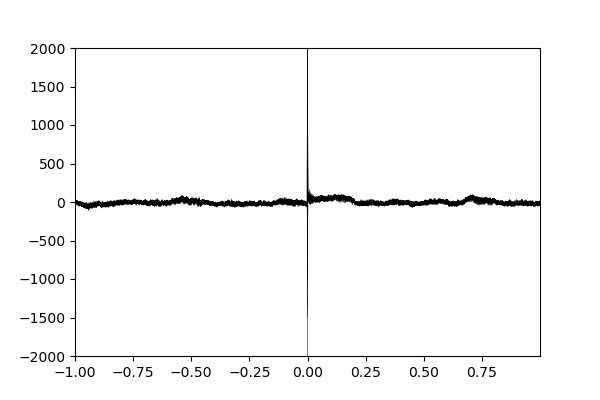

(-2000, 2000)

In [34]:
## Plot all chs, one trial ##
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(timex, trace_data[:,:,90], color='k', linewidth=0.6, alpha=0.5)
ax.set_xlim([timex[0], timex[-1]])
ax.set_ylim([-2000, 2000])

Now, excluding the bad trials, find bad channels

In [42]:
CH_RMS_THRESH = 100
TRIAL_FRACTION_THRESH = 0.25

## Look at baseline RMS first ##
rms_good_chs = np.nonzero(np.mean(baseline_rms_values[:,good_trials], axis=1) < CH_RMS_THRESH)[0]
print('Number of chs with low baseline noise: {:d}'.format(len(rms_good_chs)))

## Look at voltage diff ##
# diff_good_chs = np.nonzero(np.median(meandiff[:,good_trials], axis=1) > VOLT_DIFF_THRESH)[0]
diff_good_chs = np.nonzero(np.mean(meandiff[:,good_trials] > VOLT_DIFF_THRESH, axis=1) < TRIAL_FRACTION_THRESH)[0]
print('Number of chs with low voltage difference: {:d}'.format(len(diff_good_chs)))
# print(', '.join(map(str, diff_good_chs)))

## Combine ##
good_chs = np.intersect1d(rms_good_chs, diff_good_chs, assume_unique=True)
print('Total good chs: {:d}'.format(good_chs.shape[0]))

Number of chs with low baseline noise: 30
Number of chs with low voltage difference: 30
Total good chs: 30


In [36]:
print(good_chs)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


In [37]:
np.median(baseline_rms_values[:,good_trials], axis=1)

array([25.317081, 29.67726 , 33.450947, 37.39424 , 38.772404, 35.736   ,
       35.776306, 38.04723 , 40.432423, 40.312614, 38.98999 , 36.832645,
       40.279778, 36.80306 , 38.282154, 44.99391 , 40.558083, 45.47764 ,
       42.97864 , 41.467945, 40.342846, 42.948532, 36.869087, 37.980038,
       39.20086 , 33.96228 , 32.873768, 36.007782, 32.834778, 28.704603],
      dtype=float32)

In [38]:
np.mean(meandiff[:,good_trials] > VOLT_DIFF_THRESH, axis=1)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.03539823, 0.        , 0.        ,
       0.00884956, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00884956, 0.00884956, 0.        , 0.        ,
       0.00884956, 0.        , 0.        , 0.        , 0.        ])

<IPython.core.display.Javascript object>


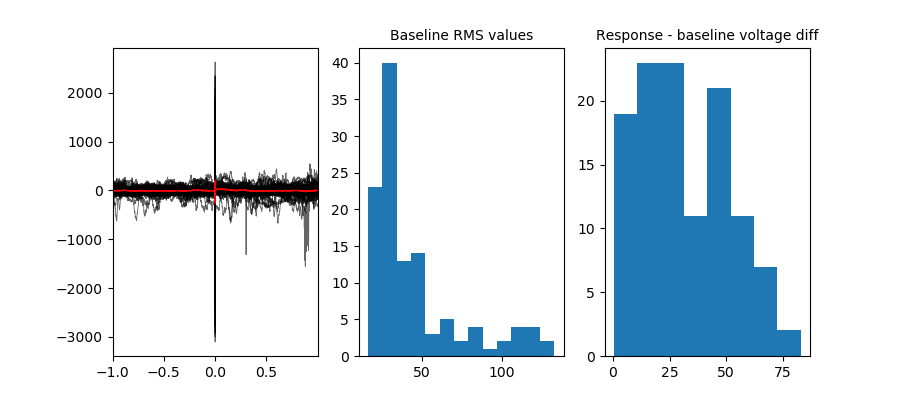

Text(0.5, 1.0, 'Response - baseline voltage diff')

In [43]:
## single ch, only good trials ##
cha = 2

sc_trace_data = sub_traces[pickmouse][pickstim][pickparam][picksweep][1][:, cha, good_trials]
sc_timex = sub_traces[pickmouse][pickstim][pickparam][picksweep][0]

## Evaluate RMS in baseline for histogram ##
baseline_inds = sc_timex < -0.001
sc_baseline_rms_values = rms(sc_trace_data[baseline_inds, :])

## Response - baseline voltage diff ##
blinds = np.squeeze(np.argwhere((sc_timex > -0.003) & (sc_timex < -0.001)))
respinds = np.squeeze(np.argwhere((sc_timex > 0.001) & (sc_timex < 0.003)))
sc_meandiff = np.abs(np.mean(sc_trace_data[respinds,:], axis=0) - np.mean(sc_trace_data[blinds,:], axis=0))

fig, axs = plt.subplots(1, 3, figsize=(9,4))

axs[0].plot(sc_timex, sc_trace_data, color='k', linewidth=0.6, alpha=0.6)
axs[0].plot(sc_timex, np.mean(sc_trace_data, axis=1), color='r', linewidth=1)
axs[0].set_xlim([sc_timex[0], sc_timex[-1]])

axs[1].hist(sc_baseline_rms_values)
axs[1].set_title('Baseline RMS values')

axs[2].hist(sc_meandiff)
axs[2].set_title('Response - baseline voltage diff')

RMS noise

<IPython.core.display.Javascript object>


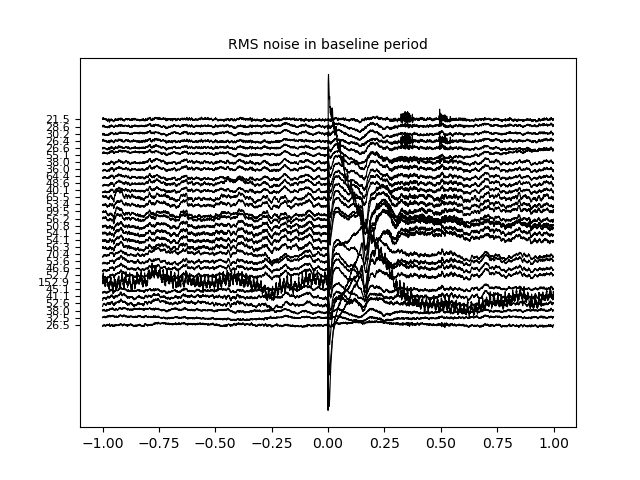

Text(0.5, 1.0, 'RMS noise in baseline period')

In [17]:
picktrial = 20

pickdata = sub_traces[pickmouse][pickstim][pickparam][picksweep][1][:, :, picktrial]
picktime = sub_traces[pickmouse][pickstim][pickparam][picksweep][0]
baseline_inds = picktime < -0.001
rms_chs = rms(pickdata[baseline_inds, :])

sep = 200
fig, ax = plt.subplots()

rms_labels = []
for chi in eegchs:
    rms_labels.append('{:.1f}'.format(rms_chs[chi]))
    ax.plot(picktime, pickdata[:, chi] + (chi * sep), color='k', linewidth=0.8)
    
ax.set_yticks(np.arange(0, len(eegchs) * sep, sep))
ax.set_yticklabels(rms_labels, fontsize=8)
ax.set_title('RMS noise in baseline period')

Compare baseline avg voltage/STD to response avg

<IPython.core.display.Javascript object>


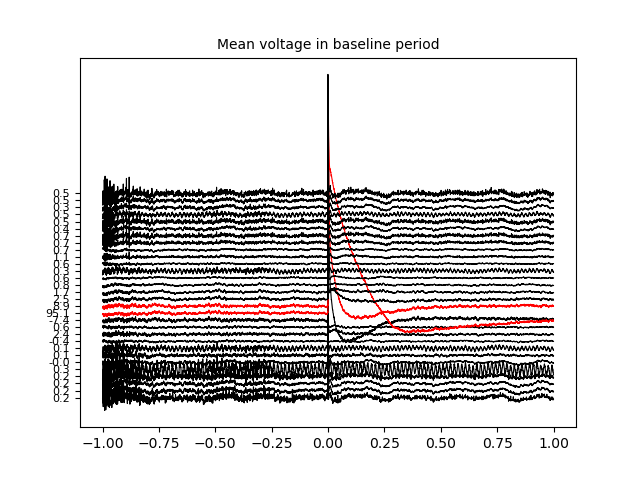

Text(0.5, 1.0, 'Mean voltage in baseline period')

In [28]:
picktrial = 54

pickdata = sub_traces[pickmouse][pickstim][pickparam][picksweep][1][:, :, picktrial]
picktime = sub_traces[pickmouse][pickstim][pickparam][picksweep][0]
baseline_inds = picktime < -0.001
baseline_mean = np.mean(pickdata[baseline_inds, :], axis=0)
baseline_std = np.std(pickdata[baseline_inds, :], axis=0)

early_inds = np.squeeze(np.argwhere((picktime > 0.001) & (picktime < 0.15)))
resp_mean = np.mean(pickdata[early_inds, :], axis=0)

sep = 200
fig, ax = plt.subplots()

blmean_labels = []
resp_mag = []
resp_stds = []
for chi in eegchs:
    if np.abs(resp_mean[chi]) > (baseline_mean[chi] + 8*baseline_std[chi]):
        line_color = 'r'
    else:
        line_color = 'k'
    blmean_labels.append('{:.1f}'.format(baseline_mean[chi]))
    resp_mag.append('{:.1f}'.format(np.abs(resp_mean[chi])))
    resp_stds.append('{:.1f}'.format((resp_mean[chi] - baseline_mean[chi])/baseline_std[chi]))
    ax.plot(picktime, pickdata[:, chi] + (chi * sep), color=line_color, linewidth=0.8)
    
ax.set_yticks(np.arange(0, len(eegchs) * sep, sep))
ax.set_yticklabels(resp_stds, fontsize=8)
ax.set_title('Mean voltage in baseline period')

Max voltage in whole window

<IPython.core.display.Javascript object>


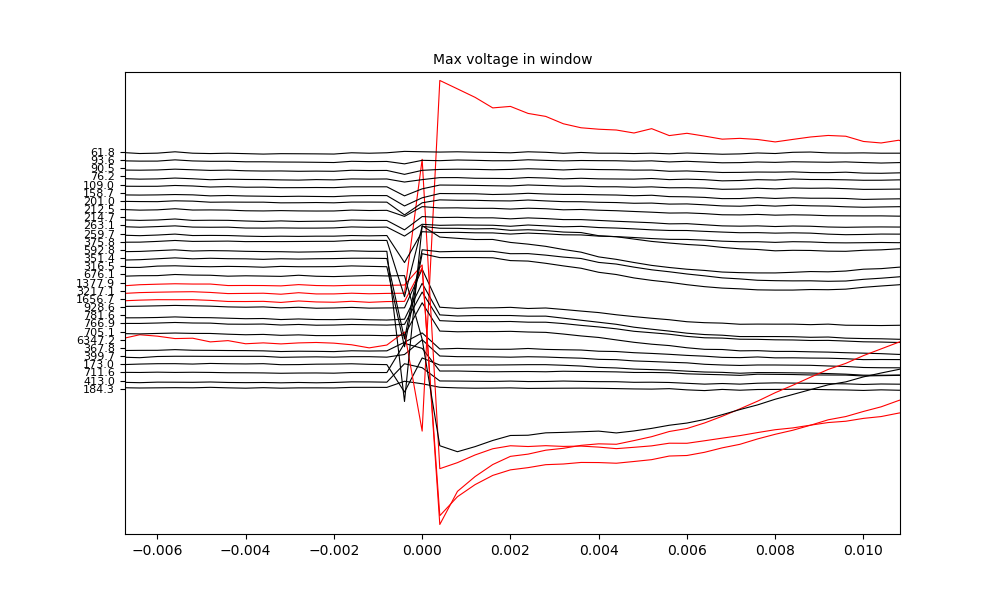

Text(0.5, 1.0, 'Max voltage in window')

In [18]:
picktrial = 30
maxv_thresh = 1000 # uV

pickdata = sub_traces[pickmouse][pickstim][pickparam][picksweep][1][:, :, picktrial]
picktime = sub_traces[pickmouse][pickstim][pickparam][picksweep][0]

sep = 200
fig, ax = plt.subplots(figsize=(10,6))
maxv = []
max_labels = []
for chi in eegchs:
    maxv.append(np.max(pickdata[:, chi]))
    max_labels.append('{:.1f}'.format(maxv[chi]))
    if maxv[chi] > maxv_thresh:
        linecolor = 'r'
    else:
        linecolor = 'k'
    ax.plot(picktime, pickdata[:, chi] + (chi * sep), color=linecolor, linewidth=0.8)

ax.set_xlim([picktime[0], picktime[-1]])
ax.set_yticks(np.arange(0, len(eegchs) * sep, sep))
ax.set_yticklabels(max_labels, fontsize=8)
ax.set_title('Max voltage in window')

Max voltage in window 0-100 ms

<IPython.core.display.Javascript object>


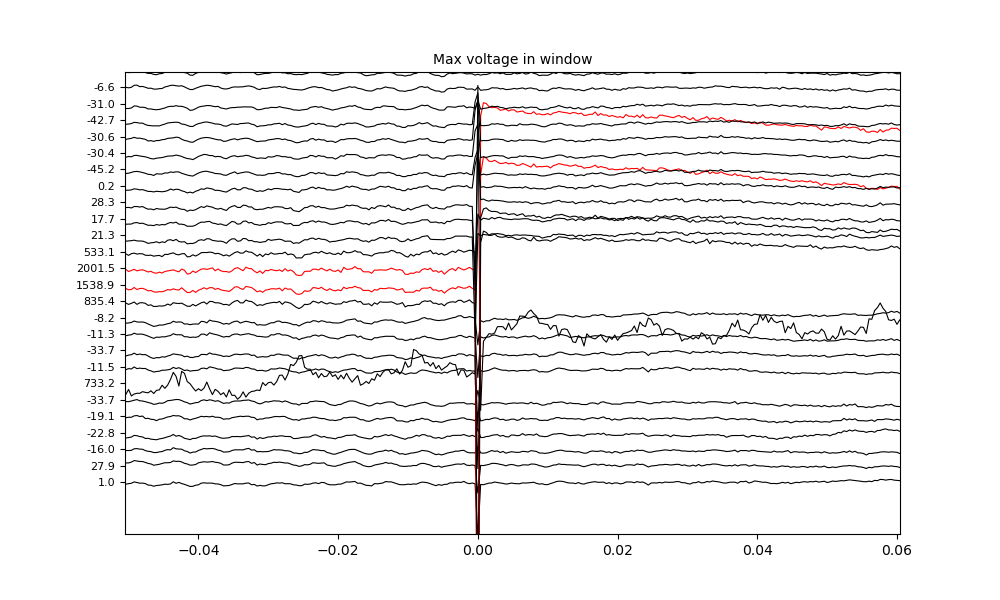

Text(0.5, 1.0, 'Max voltage in window')

In [24]:
picktrial = 48
maxv_thresh = 1000 # uV

pickdata = sub_traces[pickmouse][pickstim][pickparam][picksweep][1][:, :, picktrial]
picktime = sub_traces[pickmouse][pickstim][pickparam][picksweep][0]
early_inds = np.squeeze(np.argwhere((picktime > 0.001) & (picktime < 0.005)))

sep = 200
fig, ax = plt.subplots(figsize=(10,6))
maxv = []
max_labels = []
for chi in eegchs:
    maxv.append(np.max(pickdata[early_inds, chi]))
    max_labels.append('{:.1f}'.format(maxv[chi]))
    if maxv[chi] > maxv_thresh:
        linecolor = 'r'
    else:
        linecolor = 'k'
    ax.plot(picktime, pickdata[:, chi] + (chi * sep), color=linecolor, linewidth=0.8)

ax.set_xlim([picktime[0], picktime[-1]])
ax.set_yticks(np.arange(0, len(eegchs) * sep, sep))
ax.set_yticklabels(max_labels, fontsize=8)
ax.set_title('Max voltage in window')

Max voltage in window 1-10 ms

In [ ]:
picktrial = 36
maxv_thresh = 1000 # uV

pickdata = sub_traces[pickmouse][pickstim][pickparam][picksweep][1][:, :, picktrial]
picktime = sub_traces[pickmouse][pickstim][pickparam][picksweep][0]
early_inds = np.squeeze(np.argwhere((picktime > 0.001) & (picktime < 0.01)))

sep = 200
fig, ax = plt.subplots(figsize=(10,6))
maxv = []
max_labels = []
for chi in eegchs:
    maxv.append(np.max(np.abs(pickdata[early_inds, chi])))
    max_labels.append('{:.1f}'.format(maxv[chi]))
    if maxv[chi] > maxv_thresh:
        linecolor = 'r'
    else:
        linecolor = 'k'
    ax.plot(picktime, pickdata[:, chi] + (chi * sep), color=linecolor, linewidth=0.8)

ax.set_xlim([picktime[0], picktime[-1]])
ax.set_yticks(np.arange(0, len(eegchs) * sep, sep))
ax.set_yticklabels(max_labels, fontsize=8)
ax.set_title('Max voltage in window')

Mean voltage in window 1-10 ms

In [ ]:
picktrial = 24
meanv_thresh = 500 # uV

pickdata = sub_traces[pickmouse][pickstim][pickparam][picksweep][1][:, :, picktrial]
picktime = sub_traces[pickmouse][pickstim][pickparam][picksweep][0]
early_inds = np.squeeze(np.argwhere((picktime > 0.001) & (picktime < 0.1)))

sep = 200
fig, ax = plt.subplots(figsize=(10,6))
meanv = []
mean_labels = []
for chi in eegchs:
    meanv.append(np.abs(np.mean(pickdata[early_inds, chi])))
    mean_labels.append('{:.1f}'.format(meanv[chi]))
    if meanv[chi] > meanv_thresh:
        linecolor = 'r'
    else:
        linecolor = 'k'
    ax.plot(picktime, pickdata[:, chi] + (chi * sep), color=linecolor, linewidth=0.8)

ax.set_xlim([picktime[0], picktime[-1]])
ax.set_yticks(np.arange(0, len(eegchs) * sep, sep))
ax.set_yticklabels(mean_labels, fontsize=8)
ax.set_title('Mean voltage in window')

Mean derivative of voltage in window 1-10 ms

In [ ]:
picktrial = 36
diffv_thresh = 45 # uV/time

pickdata = sub_traces[pickmouse][pickstim][pickparam][picksweep][1][:, :, picktrial]
picktime = sub_traces[pickmouse][pickstim][pickparam][picksweep][0]
early_inds = np.squeeze(np.argwhere((picktime > 0.001) & (picktime < 0.01)))

sep = 300
fig, ax = plt.subplots(figsize=(10,6))
diffv = []
diff_labels = []
for chi in eegchs:
    diffv.append(np.mean(np.abs(np.diff(pickdata[early_inds, chi], axis=0)), axis=0))
    diff_labels.append('{:.1f}'.format(diffv[chi]))
    if diffv[chi] > diffv_thresh:
        linecolor = 'r'
    else:
        linecolor = 'k'
    ax.plot(picktime, pickdata[:, chi] + (chi * sep), color=linecolor, linewidth=0.8)

ax.set_xlim([picktime[0], picktime[-1]])
ax.set_yticks(np.arange(0, len(eegchs) * sep, sep))
ax.set_yticklabels(diff_labels, fontsize=8)
ax.set_title('Mean derivative in early window')

Duration of response above baseline +/- STD

In [ ]:
picktrial = 47

pickdata = sub_traces[pickmouse][pickstim][pickparam][picksweep][1][:, :, picktrial]
picktime = sub_traces[pickmouse][pickstim][pickparam][picksweep][0]
baseline_inds = picktime < -0.001
baseline_mean = np.mean(pickdata[baseline_inds, :], axis=0)
baseline_std = np.std(pickdata[baseline_inds, :], axis=0)

early_inds = np.squeeze(np.argwhere((picktime > 0.001) & (picktime < 0.1)))
resp_zscore = np.abs((pickdata[early_inds,:] - baseline_mean) / baseline_std)
highdur = np.sum((resp_zscore > 3), axis=0)

sep = 200
fig, ax = plt.subplots()

dur_labels = []
for chi in eegchs:
    if highdur[chi] > 0.5*len(early_inds):
        line_color = 'r'
    else:
        line_color = 'k'
    dur_labels.append('{:.0f}'.format(highdur[chi]))
    ax.plot(picktime, pickdata[:, chi] + (chi * sep), color=line_color, linewidth=0.8)
    
ax.set_yticks(np.arange(0, len(eegchs) * sep, sep))
ax.set_yticklabels(dur_labels, fontsize=8)
ax.set_title('Duration of response above z-threshold')

Compare instantaneous response to early max voltage.

In [ ]:
pickdata = sub_traces[pickmouse][pickstim][pickparam][picksweep][1]
picktime = sub_traces[pickmouse][pickstim][pickparam][picksweep][0]

stiminds = np.squeeze(np.argwhere((picktime > -0.001) & (picktime < 0.001)))
respinds = np.squeeze(np.argwhere((picktime > 0.001) & (picktime < 0.1)))

stim_max = np.max(pickdata[stiminds,:,:], axis=0)
stim_min = np.min(pickdata[stiminds,:,:], axis=0)

resp_mag = np.max(np.abs(pickdata[respinds,:,:]), axis=0)

chcolors = cm.rainbow(np.linspace(0, 1, len(eegchs)))
fig, axs = plt.subplots(1, 2, figsize=(9,5), constrained_layout=True)

for chi in eegchs:
    if chi in bad_chs[pickmouse]:
        axs[0].plot(stim_max[chi,:], resp_mag[chi,:], 'x', color=chcolors[chi]) #, marker='x')
        axs[1].plot(stim_min[chi,:], resp_mag[chi,:], 'x', color=chcolors[chi]) #, marker='x')
    else:
        axs[0].plot(stim_max[chi,:], resp_mag[chi,:], '.', color=chcolors[chi]) #, marker='.')
        axs[1].plot(stim_min[chi,:], resp_mag[chi,:], '.', color=chcolors[chi]) #, marker='.')
        
axs[0].set_xlabel('max stim artifact voltage')
axs[1].set_xlabel('min stim artifact voltage')

axs[0].set_ylabel('max abs response voltage')
axs[1].set_ylabel('max abs response voltage')

Compare early max voltage to early response z-score.

In [ ]:
pickdata = sub_traces[pickmouse][pickstim][pickparam][picksweep][1]
picktime = sub_traces[pickmouse][pickstim][pickparam][picksweep][0]

blinds = np.squeeze(np.argwhere(picktime < -0.001))
respinds = np.squeeze(np.argwhere((picktime > 0.001) & (picktime < 0.1)))

blmean = np.mean(pickdata[blinds,:,:], axis=0)
blstd = np.std(pickdata[blinds,:,:], axis=0)

resp_mag = np.max(np.abs(pickdata[respinds,:,:]), axis=0)
resp_mean = np.mean(pickdata[respinds,:,:], axis=0)
resp_zscore = (resp_mean - blmean) / blstd

chcolors = cm.rainbow(np.linspace(0, 1, len(eegchs)))
fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True)

for chi in eegchs:
    if chi in bad_chs[pickmouse]:
        ax.plot(resp_mag[chi,:], resp_zscore[chi,:], 'x', color=chcolors[chi]) #, marker='x')
    else:
        ax.plot(resp_mag[chi,:], resp_zscore[chi,:], '.', color=chcolors[chi]) #, marker='.')
        
ax.set_xlabel('max abs response voltage')
ax.set_ylabel('mean response z-score')

Compare early max voltage to early mean voltage.

<IPython.core.display.Javascript object>


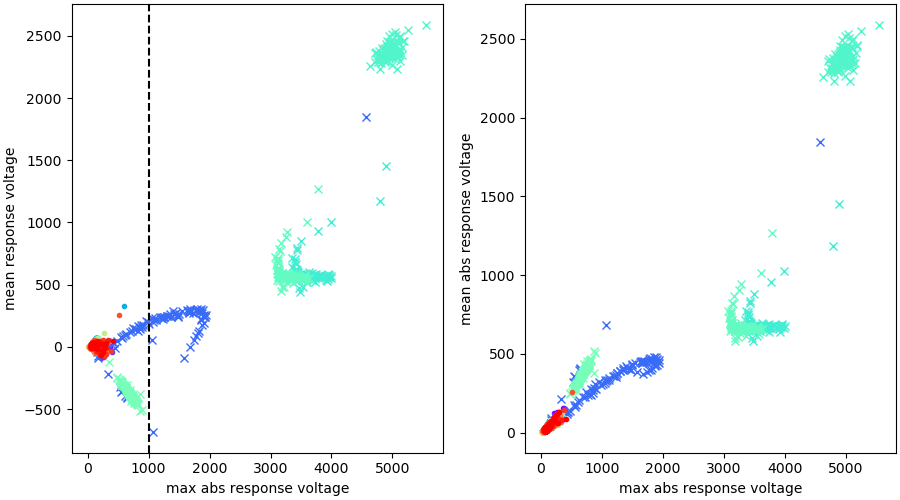

In [22]:
pickdata = sub_traces[pickmouse][pickstim][pickparam][picksweep][1]
picktime = sub_traces[pickmouse][pickstim][pickparam][picksweep][0]

respinds = np.squeeze(np.argwhere((picktime > 0.001) & (picktime < 0.15)))

resp_max = np.max(np.abs(pickdata[respinds,:,:]), axis=0)
absresp_mean = np.mean(np.abs(pickdata[respinds,:,:]), axis=0)
resp_mean = np.mean(pickdata[respinds,:,:], axis=0)

chcolors = cm.rainbow(np.linspace(0, 1, len(eegchs)))
fig, axs = plt.subplots(1, 2, figsize=(9,5), constrained_layout=True)

for chi in eegchs:
    if chi in bad_chs[pickmouse]:
        axs[0].plot(resp_max[chi,:], resp_mean[chi,:], 'x', color=chcolors[chi])
        axs[1].plot(resp_max[chi,:], absresp_mean[chi,:], 'x', color=chcolors[chi])
    else:
        axs[0].plot(resp_max[chi,:], resp_mean[chi,:], '.', color=chcolors[chi])
        axs[1].plot(resp_max[chi,:], absresp_mean[chi,:], '.', color=chcolors[chi])
        
axs[0].set_xlabel('max abs response voltage')
axs[0].set_ylabel('mean response voltage')

axs[1].set_xlabel('max abs response voltage')
axs[1].set_ylabel('mean abs response voltage')

axs[0].axvline(1000, color='k', linestyle='--')
# axs[0].axhline(len(respinds)*0.5, color='k', linestyle='--')

Compare early max voltage to number of early response samples above z-score threshold.

<IPython.core.display.Javascript object>


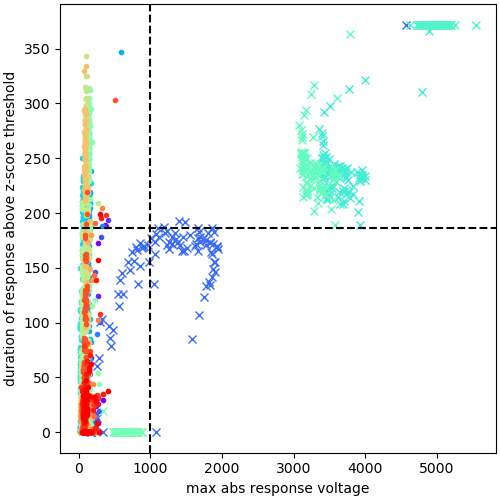

In [21]:
pickdata = sub_traces[pickmouse][pickstim][pickparam][picksweep][1]
picktime = sub_traces[pickmouse][pickstim][pickparam][picksweep][0]

blinds = np.squeeze(np.argwhere(picktime < -0.001))
respinds = np.squeeze(np.argwhere((picktime > 0.001) & (picktime < 0.15)))

blmean = np.mean(pickdata[blinds,:,:], axis=0)
blstd = np.std(pickdata[blinds,:,:], axis=0)

resp_mag = np.max(np.abs(pickdata[respinds,:,:]), axis=0)
resp_zscore = (pickdata[respinds,:,:] - blmean) / blstd
highdur = np.sum((resp_zscore > 3), axis=0)

chcolors = cm.rainbow(np.linspace(0, 1, len(eegchs)))
fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True)

for chi in eegchs:
    if chi in bad_chs[pickmouse]:
        ax.plot(resp_mag[chi,:], highdur[chi,:], 'x', color=chcolors[chi]) #, marker='x')
    else:
        ax.plot(resp_mag[chi,:], highdur[chi,:], '.', color=chcolors[chi]) #, marker='.')
        
ax.set_xlabel('max abs response voltage')
ax.set_ylabel('duration of response above z-score threshold')

ax.axvline(1000, color='k', linestyle='--')
ax.axhline(len(respinds)*0.5, color='k', linestyle='--')

Compare baseline mean voltage to super early voltage.

<IPython.core.display.Javascript object>


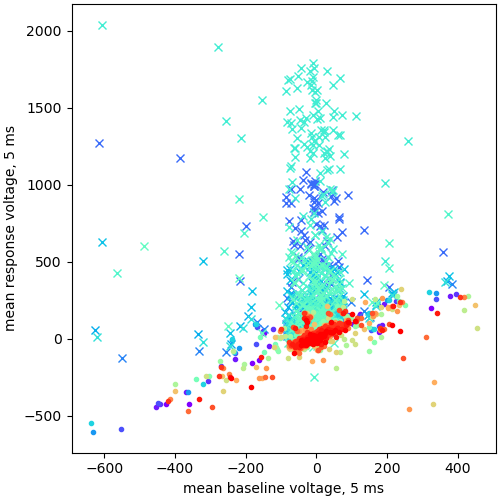

Text(0, 0.5, 'mean response voltage, 5 ms')

In [45]:
pickdata = sub_traces[pickmouse][pickstim][pickparam][picksweep][1]
picktime = sub_traces[pickmouse][pickstim][pickparam][picksweep][0]

blinds = np.squeeze(np.argwhere((picktime > -0.005) & (picktime < -0.001)))
respinds = np.squeeze(np.argwhere((picktime > 0.001) & (picktime < 0.005)))

blmean = np.mean(pickdata[blinds,:,:], axis=0)
blstd = np.std(pickdata[blinds,:,:], axis=0)

resp_mean = np.mean(pickdata[respinds,:,:], axis=0)
# resp_zscore = (pickdata[respinds,:,:] - blmean) / blstd
# highdur = np.sum((resp_zscore > 3), axis=0)

chcolors = cm.rainbow(np.linspace(0, 1, len(eegchs)))
fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True)

for chi in eegchs:
    if chi in bad_chs[pickmouse]:
        ax.plot(blmean[chi,:], resp_mean[chi,:], 'x', color=chcolors[chi]) #, marker='x')
    else:
        ax.plot(blmean[chi,:], resp_mean[chi,:], '.', color=chcolors[chi]) #, marker='.')
        
ax.set_xlabel('mean baseline voltage, 5 ms')
ax.set_ylabel('mean response voltage, 5 ms')

# ax.axvline(1000, color='k', linestyle='--')
# ax.axhline(len(respinds)*0.5, color='k', linestyle='--')

Compare difference between baseline mean and early response mean to max response voltage.

<IPython.core.display.Javascript object>


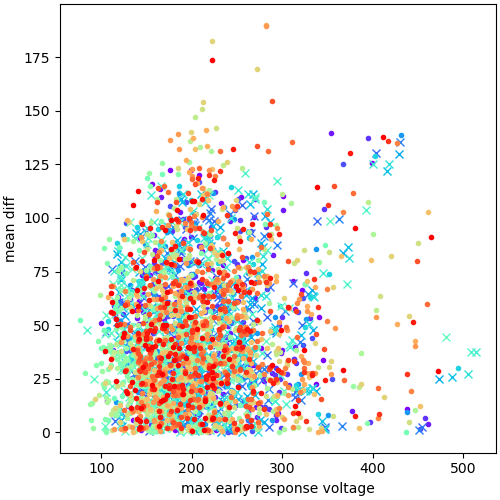

Text(0, 0.5, 'mean diff')

In [52]:
pickdata = sub_traces[pickmouse][pickstim][pickparam][picksweep][1]
picktime = sub_traces[pickmouse][pickstim][pickparam][picksweep][0]

blinds = np.squeeze(np.argwhere((picktime > -0.003) & (picktime < -0.001)))
respinds = np.squeeze(np.argwhere((picktime > 0.001) & (picktime < 0.003)))
earlyresp = np.squeeze(np.argwhere((picktime > 0.001) & (picktime < 0.1)))

meandiff = np.abs(np.mean(pickdata[respinds,:,:], axis=0) - np.mean(pickdata[blinds,:,:], axis=0))

resp_mag = np.max(np.abs(pickdata[earlyresp,:,:]), axis=0)

chcolors = cm.rainbow(np.linspace(0, 1, len(eegchs)))
fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True)

for chi in eegchs:
    if chi in bad_chs[pickmouse]:
        ax.plot(resp_mag[chi,:], meandiff[chi,:], 'x', color=chcolors[chi]) #, marker='x')
    else:
        ax.plot(resp_mag[chi,:], meandiff[chi,:], '.', color=chcolors[chi]) #, marker='.')
        
ax.set_xlabel('max early response voltage')
ax.set_ylabel('mean diff')

# ax.axvline(1000, color='k', linestyle='--')
# ax.axhline(len(respinds)*0.5, color='k', linestyle='--')

Compare early voltage to z-score early voltage.

<IPython.core.display.Javascript object>


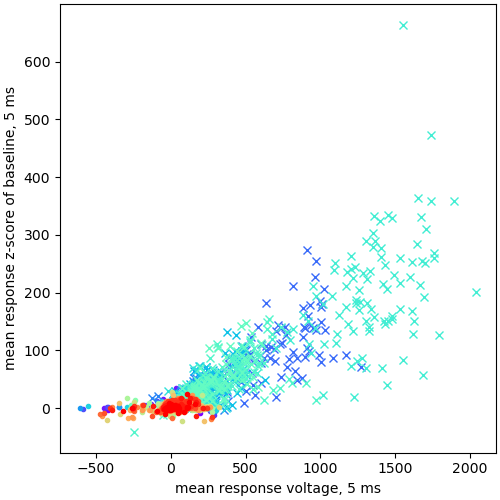

Text(0, 0.5, 'mean response z-score of baseline, 5 ms')

In [44]:
pickdata = sub_traces[pickmouse][pickstim][pickparam][picksweep][1]
picktime = sub_traces[pickmouse][pickstim][pickparam][picksweep][0]

blinds = np.squeeze(np.argwhere((picktime > -0.005) & (picktime < -0.001)))
respinds = np.squeeze(np.argwhere((picktime > 0.001) & (picktime < 0.005)))

blmean = np.mean(pickdata[blinds,:,:], axis=0)
blstd = np.std(pickdata[blinds,:,:], axis=0)

resp_mean = np.mean(pickdata[respinds,:,:], axis=0)
resp_zscore = np.mean(((pickdata[respinds,:,:] - blmean) / blstd), axis=0)
# resp_zscore = (resp_mean - blmean) / blstd
# highdur = np.sum((resp_zscore > 3), axis=0)

chcolors = cm.rainbow(np.linspace(0, 1, len(eegchs)))
fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True)

for chi in eegchs:
    if chi in bad_chs[pickmouse]:
        ax.plot(resp_mean[chi,:], resp_zscore[chi,:], 'x', color=chcolors[chi]) #, marker='x')
    else:
        ax.plot(resp_mean[chi,:], resp_zscore[chi,:], '.', color=chcolors[chi]) #, marker='.')
        
ax.set_xlabel('mean response voltage, 5 ms')
ax.set_ylabel('mean response z-score of baseline, 5 ms')

# ax.axvline(1000, color='k', linestyle='--')
# ax.axhline(len(respinds)*0.5, color='k', linestyle='--')

#### Calculate rms noise in baseline period AND max voltage in early response window for all chs, all trials

In [ ]:
early_window = [0.001, 0.01] # looking in window from 1 to 10 ms for high absolute voltage

## Loop through all stim events/sweeps and calculate baseline rms
baseline_rms_alltrials = {}
early_max_v = {}
for mousei in sub_traces.keys():
    print(mousei)
    baseline_rms_alltrials[mousei] = {}
    early_max_v[mousei] = {}
    for st_type in sub_traces[mousei].keys():
        baseline_rms_alltrials[mousei][st_type] = {}
        early_max_v[mousei][st_type] = {}
        for parami in sub_traces[mousei][st_type].keys():
            baseline_rms_alltrials[mousei][st_type][parami] = {}
            early_max_v[mousei][st_type][parami] = {}
            for sweepi, traces_list in sub_traces[mousei][st_type][parami].items():
#                 print('{} {}, sweep {:d}'.format(st_type, str(parami), sweepi))
                traces_array = traces_list[1]
                time_array = traces_list[0]
                
                ## RMS of baseline signal ##
                baseline_inds = time_array < -0.001
                baseline_rms_alltrials[mousei][st_type][parami][sweepi] = rms(traces_array[baseline_inds, :, :], maxis=0)
                
                ## Max voltage in early response window ##
                early_inds = np.squeeze(np.argwhere((time_array > early_window[0]) & (time_array < early_window[1])))
                early_max_v[mousei][st_type][parami][sweepi] = np.max(np.abs(traces_array[early_inds, :, :]), axis=0)

Look at both rms and max

In [ ]:
pickmouse = '543396'
pickstim = 'biphasic'
pickparam = '80'
picksweep = 0
picktrial = 55

hi_noise_thresh = 100.0 # default = 50.0 from Npx pipeline analysis
lo_noise_thresh = 3.0 # default = 3.0 from Npx pipeline analysis
volt_thresh = 500 # uV

pickdata = sub_traces[pickmouse][pickstim][pickparam][picksweep][1][:, :, picktrial]
picktime = sub_traces[pickmouse][pickstim][pickparam][picksweep][0]

rms_mask = np.ones((len(eegchs),), dtype=bool)
rms_mask[np.median(baseline_rms_alltrials[pickmouse][pickstim][pickparam][picksweep], 1) > hi_noise_thresh] = False
rms_mask[np.median(baseline_rms_alltrials[pickmouse][pickstim][pickparam][picksweep], 1) < lo_noise_thresh] = False

earlymax_mask = np.ones((len(eegchs),), dtype=bool)
earlymax_mask[np.median(early_max_v[pickmouse][pickstim][pickparam][picksweep], 1) > volt_thresh] = False

sep = 300
fig, ax = plt.subplots()

for chi in eegchs:
    if rms_mask[chi] and earlymax_mask[chi]:
        ax.plot(picktime, pickdata[:, chi] + (chi * sep), color='k', linewidth=0.8)
    elif rms_mask[chi] and not earlymax_mask[chi]:
        ax.plot(picktime, pickdata[:, chi] + (chi * sep), color='r', linewidth=0.8)
    elif earlymax_mask[chi] and not rms_mask[chi]:
        ax.plot(picktime, pickdata[:, chi] + (chi * sep), color='g', linewidth=0.8)
    else:
        ax.plot(picktime, pickdata[:, chi] + (chi * sep), color='m', linewidth=0.8)
    
ax.set_yticks(np.arange(0, len(eegchs) * sep, sep))
ax.set_yticklabels(eegchs, fontsize=8)
ax.set_title('Chs flagged red if max voltage, green if baseline RMS noise')

#### Make a list of our bad chs and the ones found using the above metrics

In [ ]:
hi_noise_thresh = 100.0 # default = 50.0 from Npx pipeline analysis
lo_noise_thresh = 3.0 # default = 3.0 from Npx pipeline analysis
volt_thresh = 1000 # uV
trial_fraction_thresh = 0.1

sweepi = 0
for mousei in early_max_v.keys():
    print('')
    print(mousei)
    print(bad_chs[mousei])
    
    for st_type in early_max_v[mousei].keys():
        
        for parami in early_max_v[mousei][st_type].keys():
            print('{} {}, sweep {:d}'.format(st_type, str(parami), sweepi))
            
            ## RMS, True = bad ch ##
            rms_mask = np.zeros((len(eegchs),), dtype=bool)
            rms_mask[np.median(baseline_rms_alltrials[mousei][st_type][parami][sweepi], 1) > hi_noise_thresh] = True
            rms_mask[np.median(baseline_rms_alltrials[mousei][st_type][parami][sweepi], 1) < lo_noise_thresh] = True

            ## early max voltage, True = bad ch ##
            earlymax_mask = np.zeros((len(eegchs),), dtype=bool)
            trials_over_thresh = early_max_v[mousei][st_type][parami][sweepi] > volt_thresh
            earlymax_mask[np.mean(trials_over_thresh, axis=1) > trial_fraction_thresh] = True
            
            print(eegchs[np.any([rms_mask, earlymax_mask], axis=0)])

## Bad trials: looking at individual subjects and testing noise metrics

#### Plot trials

In [ ]:
pickmouse = '546655'
pickstim = 'biphasic'
pickparam = '50'
picksweep = 1

In [ ]:
pickstimlog = get_bad_chs_count(sub_exp[pickmouse])
pickstimlog.head()

In [ ]:
pickstimlog[700:750]

Max voltage in window 1-100 ms

In [ ]:
picktrial = 86
maxv_thresh = 1000 # uV

pickdata = sub_traces[pickmouse][pickstim][pickparam][picksweep][1][:, :, picktrial]
picktime = sub_traces[pickmouse][pickstim][pickparam][picksweep][0]
early_inds = np.squeeze(np.argwhere((picktime > 0.001) & (picktime < 0.1)))

sep = 200
fig, ax = plt.subplots(figsize=(10,6))
maxv = []
max_labels = []
for chi in eegchs:
    maxv.append(np.max(np.abs(pickdata[early_inds, chi])))
    max_labels.append('{:.1f}'.format(maxv[chi]))
    if maxv[chi] > maxv_thresh:
        linecolor = 'r'
    else:
        linecolor = 'k'
    ax.plot(picktime, pickdata[:, chi] + (chi * sep), color=linecolor, linewidth=0.8)

ax.set_xlim([picktime[0], picktime[-1]])
ax.set_yticks(np.arange(0, len(eegchs) * sep, sep))
ax.set_yticklabels(max_labels, fontsize=8)
ax.set_title('Max voltage in window')

Loop through onset times in stim log and count # of chs with large response

In [ ]:
pickstimlog['num_high_chs'].hist(by=pickstimlog['good'], bins=30)

RMS noise

In [ ]:
picktrial = 88

pickdata = sub_traces[pickmouse][pickstim][pickparam][picksweep][1][:, :, picktrial]
picktime = sub_traces[pickmouse][pickstim][pickparam][picksweep][0]
baseline_inds = picktime < -0.001
rms_chs = rms(pickdata[baseline_inds, :])

sep = 200
fig, ax = plt.subplots()

rms_labels = []
for chi in eegchs:
    rms_labels.append('{:.1f}'.format(rms_chs[chi]))
    ax.plot(picktime, pickdata[:, chi] + (chi * sep), color='k', linewidth=0.8)
    
ax.set_yticks(np.arange(0, len(eegchs) * sep, sep))
ax.set_yticklabels(rms_labels, fontsize=8)
ax.set_title('RMS noise in baseline period')

#### Looking at rms noise across all chs for one dataset

In [ ]:
recfolder = r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543396\estim_vis1_2020-09-18_12-04-46\experiment1\recording1'
exp = EEGexp(recfolder, preprocess=False, make_stim_csv=False)

In [ ]:
eeg_data, eeg_ts = exp.load_eegdata()

eeg_chs = np.arange(0,30)
eeg_data = eeg_data[:, eeg_chs]

#### calculate rms on all chs

In [ ]:
n_passes = 10
start_time = 10
skip_s_per_pass = 20
time_interval = 10
hi_noise_thresh = 50.0
lo_noise_thresh = 3.0

# using ecephys code
numChannels = len(eeg_chs)
numIterations = n_passes

rms_noise = np.zeros((numChannels, numIterations), dtype='float')

for i in range(numIterations):

    start_sample = int((start_time + skip_s_per_pass * i) * exp.ephys_params['EEG']['sample_rate'])
    end_sample = start_sample + int(time_interval * exp.ephys_params['EEG']['sample_rate'])

    for ch in range(numChannels):

        data = eeg_data[start_sample:end_sample, ch]
        median_subtr = data - np.median(data)
        rms_noise[ch,i] = rms(median_subtr) * exp.ephys_params['EEG']['bit_volts']

mask = np.ones((numChannels,), dtype=bool)
mask[np.median(rms_noise,1) > hi_noise_thresh] = False
mask[np.median(rms_noise,1) < lo_noise_thresh] = False

print(mask)

In [ ]:
print(rms_noise.shape)

In [ ]:
fig, ax = plt.subplots()

ax.plot(eeg_chs, rms_noise)
ax.axhline(lo_noise_thresh, color='r', linestyle='--', linewidth=0.8)
ax.axhline(hi_noise_thresh, color='r', linestyle='--', linewidth=0.8)